In [1]:
## My model
import QKLSTM
import Model
import QAOA
## basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## random
import random
import math
from typing import List, Callable, Tuple
## ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import minimize
## QML
import pennylane as qml
from pennylane import qaoa
import networkx as nx
## access file
import os

torch.manual_seed(42)
np.random.seed(42)
qml.math.random.seed(42)
random.seed(42)

In [15]:
import importlib
import QKLSTM 
importlib.reload(QKLSTM)
import Model 
importlib.reload(Model)

<module 'Model' from '/Users/yezhihai/Desktop/QK-QAOA/Model.py'>

## Define Model

In [2]:
"""
Define model and train
"""
# --- Model Training ---
def build_and_train_model(model_type,
                          mapping_type,
                          layers, 
                          input_feature_dim,
                          max_total_params,
                          loss_function_type,
                          qaoa_layers,
                          lr_lstm,
                          lr_mapping,
                          epochs, 
                          steps_recurrent_loop_train,
                          conv_tol_lstm,
                          Model_save_path,
                          train_set,
                          val_set,
                          time_out,
                          continue_train,
                          load_path):
    
    model = Model.LSTM(model_type = model_type,
                      mapping_type= mapping_type,
                      layers = layers,
                       input_feature_dim = input_feature_dim,
                       max_total_params = max_total_params,
                       loss_function_type = loss_function_type,
                        )
    
    if continue_train == True:
        state_dict = torch.load(load_path)
        model.load_state_dict(state_dict)
        print("load params successful!")
    
    print(f"--- Model Summary ---")
    print(model)
    lstm_params = sum(p.numel() for p in model.lstm.parameters())
    print(f"  {model_type} Parameters: {lstm_params}")
    if mapping_type == "DS":
        single_params = sum(p.numel() for p in model.single_mapping.parameters())
        print(f"  Single Mapping Parameters: {single_params}")
        double_params = sum(p.numel() for p in model.double_mapping.parameters())
        print(f"  Double Mapping Parameters: {double_params}")
    else:
        mapping_params = sum(p.numel() for p in model.mapping.parameters())
        print(f"  Mapping Parameters: {mapping_params}")

    trainer = Model.ModelTrain(model = model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = lr_lstm,
                               lr_mapping= lr_mapping,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )
    
    print(f"\n--- Training {model_type} Model ---")

    trainer.train(train_data = train_set,
                  val_data = val_set,
                  epochs = epochs,
                  conv_tol_lstm = conv_tol_lstm,
                  time_out = time_out)
    

    torch.save(model.state_dict(), f"{Model_save_path}_{model_type}_{loss_function_type}.pth")
    print("Model saved successfully!")
    
    return model, trainer


## Train Data

the size of training set is 1008


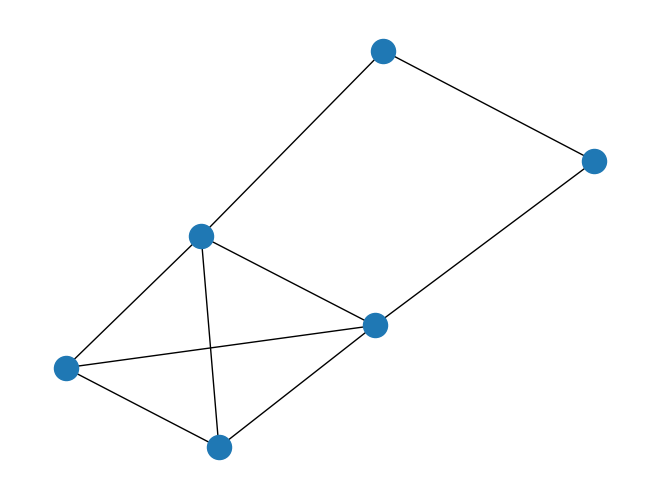

In [4]:
train_set = []
for i in range(6,10): #4
    for j in range(3,9):#6
        for _ in range(42):
            random_graph = nx.gnp_random_graph(n = i, p=j/i, seed = 42)
            train_set.append(random_graph)
nx.draw(train_set[0])
print(f"the size of training set is {len(train_set)}")

the size of training set is 5


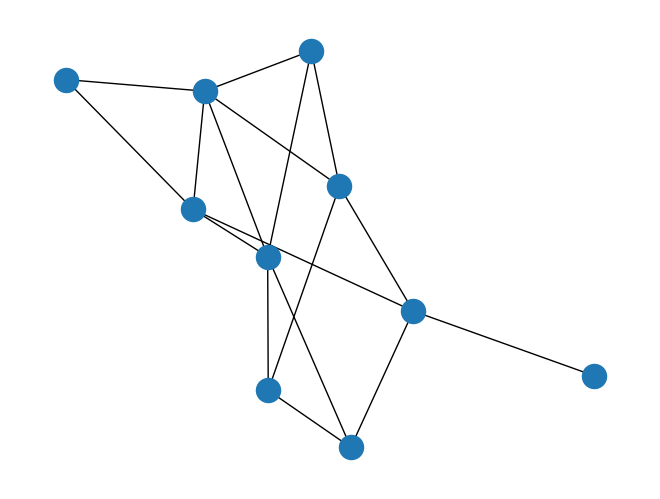

In [5]:
val_set = []

for j in range(3,8):#6
    random_graph = nx.gnp_random_graph(n = 10, p=j/10, seed = 42)
    val_set.append(random_graph)
nx.draw(val_set[0])
print(f"the size of training set is {len(val_set)}")

In [ ]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge, seed = 42)
        datapoints.append(random_graph)
    return datapoints

n_graphs = 100
n_nodes = 7
p_edge = 3.0 / n_nodes
train_set = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(train_set[0])

## Define model and Train

In [4]:
layers = 1 #LSTM
mapping_type = "ID"
input_feature_dim = 4#layer*qaoa_layers*2
max_total_params = 4    
loss_function_type = "weighted" # observed improvement or weighted
qaoa_layers = 2
epochs = 50 #1000
steps_recurrent_loop_train = 10
steps_recurrent_loop_test = 10
conv_tol_lstm = 1e-3
Results_save_path = "model_result_RMSprop"
Model_save_path = "model_params_RMSprop"
time_out = 8*60*60

lr_qaoa = 0.001
max_iter_qaoa = 300
conv_tol_qaoa = 1e-6
qaoa_optimizer = "SGD"

### LSTM

In [20]:
lstm_model, lstm_trainer = build_and_train_model(
    model_type = "LSTM",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 1e-4, #1e-4
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= False,
    load_path = None
    )

--- Model Summary ---
LSTM(
  (lstm): LSTM(5, 4, batch_first=True)
  (mapping): Identity()
)
  LSTM Parameters: 176
  Mapping Parameters: 0

--- Training LSTM Model ---

--- Starting LSTM Model Training ---
Epoch 1/50
 > Molecule 200/1008 - Loss: 4.16683102
 > Molecule 400/1008 - Loss: 5.50784445
 > Molecule 600/1008 - Loss: 5.20978546
 > Molecule 800/1008 - Loss: 4.60854721
 > Molecule 1000/1008 - Loss: 9.07502937
Epoch 1 Mean loss: 5.14573107, Mean val loss:11.70325599
Current learning rate: 0.0001000000
Epoch 2/50
 > Molecule 200/1008 - Loss: 3.32034302
 > Molecule 400/1008 - Loss: 3.74878740
 > Molecule 600/1008 - Loss: 3.00323057
 > Molecule 800/1008 - Loss: 3.11129069
 > Molecule 1000/1008 - Loss: 4.80081797
Epoch 2 Mean loss: 3.27694592, Mean val loss:7.81429085
Current learning rate: 0.0001000000
Epoch 3/50
 > Molecule 200/1008 - Loss: 1.74650002
 > Molecule 400/1008 - Loss: 2.55298996
 > Molecule 600/1008 - Loss: 2.92483568
 > Molecule 800/1008 - Loss: 2.91595793
 > Molecule 1

In [5]:
lstm_model = Model.LSTM(model_type = "LSTM",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_LSTM_model.pth")
lstm_model.load_state_dict(state_dict)
lstm_trainer = Model.ModelTrain(model = lstm_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 1e-4,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

### QK

In [554]:
qk_model, qk_trainer = build_and_train_model(
    model_type = "QK",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 5e-5,#4e-5, #8e-5,
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= False,
    load_path = None)

--- Model Summary ---
LSTM(
  (lstm): QKLSTM(
    (clayer_in): Linear(in_features=10, out_features=4, bias=True)
    (clayer_out): Linear(in_features=4, out_features=5, bias=True)
  )
  (mapping): Identity()
)
  QK Parameters: 69
  Mapping Parameters: 0

--- Training QK Model ---

--- Starting QK Model Training ---
Epoch 1/50
 > Molecule 200/1008 - Loss: 4.36315536
 > Molecule 400/1008 - Loss: 5.61318684
 > Molecule 600/1008 - Loss: 5.27280712
 > Molecule 800/1008 - Loss: 4.60627699
 > Molecule 1000/1008 - Loss: 8.35375977
Epoch 1 Mean loss: 5.18883498, Mean val loss:10.93020471
Current learning rate: 0.0000500000
Epoch 2/50
 > Molecule 200/1008 - Loss: 3.48640561
 > Molecule 400/1008 - Loss: 4.42809963
 > Molecule 600/1008 - Loss: 4.10602903
 > Molecule 800/1008 - Loss: 3.54037166
 > Molecule 1000/1008 - Loss: 6.34539175
Epoch 2 Mean loss: 4.03465826, Mean val loss:8.54388689
Current learning rate: 0.0000500000
Epoch 3/50
 > Molecule 200/1008 - Loss: 2.30475187
 > Molecule 400/1008 - 

In [6]:
qk_model = Model.LSTM(model_type = "QK",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_good_QK_model.pth")
qk_model.load_state_dict(state_dict)
qk_trainer = Model.ModelTrain(model = qk_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 5e-5,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

## Evaluate

In [496]:
def generate(min_nodes, max_nodes):
    test_set=[]
    for i in range(min_nodes, max_nodes + 1):
        for j in range(5):
            test = nx.gnp_random_graph(i, p=3 / i)
            test_set.append(test)
    return test_set

test_set = generate(8, 12)

In [7]:
test_set = []

for i in range(10,13):
    for j in range(3,i):
        random_graph = nx.gnp_random_graph(n = i, p=j/i, seed = 42)
        test_set.append(random_graph)
        
#for j in range(3,8):#3~11
#    for i in range(2):
#        random_graph = nx.gnp_random_graph(n = 12, p=j/12, seed = 42)
#        test_set.append(random_graph)
print(len(test_set))

24


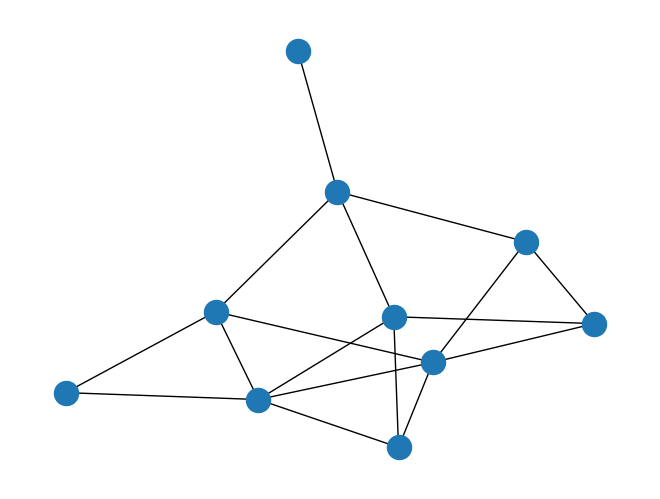

In [8]:
nx.draw(test_set[0])


--- Evaluating Model ---

--- Starting LSTM Model Testing ---
LSTM predicted energies:[5.639246076179195, 4.602959534838709, 5.2466913419013315, 5.512753269369967, 5.6445589157035325, 5.686217088465822, 5.69759025386243, 5.6991190497080995, 5.698427545797397, 5.697607043930303]
LSTM predicted params:tensor([0.2964, 0.4465, 0.7661, 0.4712])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---


/Users/yezhihai/Desktop/QK-QAOA/QAOA.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad=True, dtype=torch.float32)


Step = 50/300, Energy = 3.25080783 Ha
Step = 100/300, Energy = 3.21002147 Ha
Step = 150/300, Energy = 3.20845743 Ha
  Convergence reached at step 184
Optimization finished, final energy: 3.20837209 Ha

--- Starting QK Model Testing ---
QK predicted energies:[6.1454969904007015, 5.639471849776583, 5.42760702537929, 5.253188040948461, 5.135055166457325, 5.060376807341306, 5.01416745585505, 4.985873517422702, 4.968744714763698, 4.9585468619831845]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.22351162 Ha
Step = 100/300, Energy = 3.20919710 Ha
Step = 150/300, Energy = 3.20842685 Ha
  Convergence reached at step 177
Optimization finished, final energy: 3.20837394 Ha

--- Standard QAOA, random params ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.19199327 Ha
Step = 100/300, Energy = 4.67261108 Ha
Step = 150/300, Energy = 4.47106851 Ha
Step = 200/300, Energy = 4

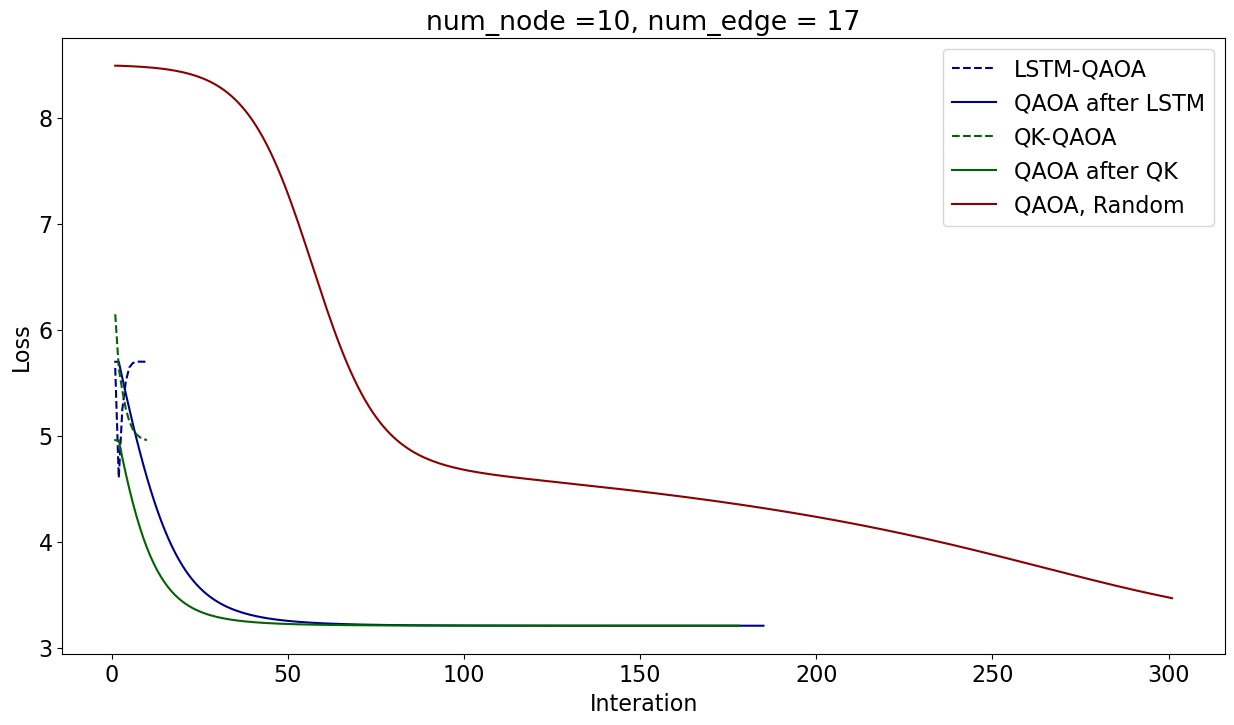


--- Starting LSTM Model Testing ---
LSTM predicted energies:[6.694031989291525, 5.218796904366641, 5.6048276030912065, 5.8149871738966805, 5.959273493224935, 6.012829785479362, 6.028733085872213, 6.030734849257677, 6.029412229920412, 6.027984587307339]
LSTM predicted params:tensor([0.2897, 0.4433, 0.7604, 0.4732])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.73976196 Ha
Step = 100/300, Energy = 3.73591669 Ha
  Convergence reached at step 114
Optimization finished, final energy: 3.73589252 Ha

--- Starting QK Model Testing ---
QK predicted energies:[7.1176285363078104, 6.221414421086369, 5.777886102470417, 5.4796047962377425, 5.296343271173141, 5.186468186345359, 5.1206065926664746, 5.081052104735218, 5.057365241564952, 5.043321718483206]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.73704697 Ha
Step = 100/300, Energy 

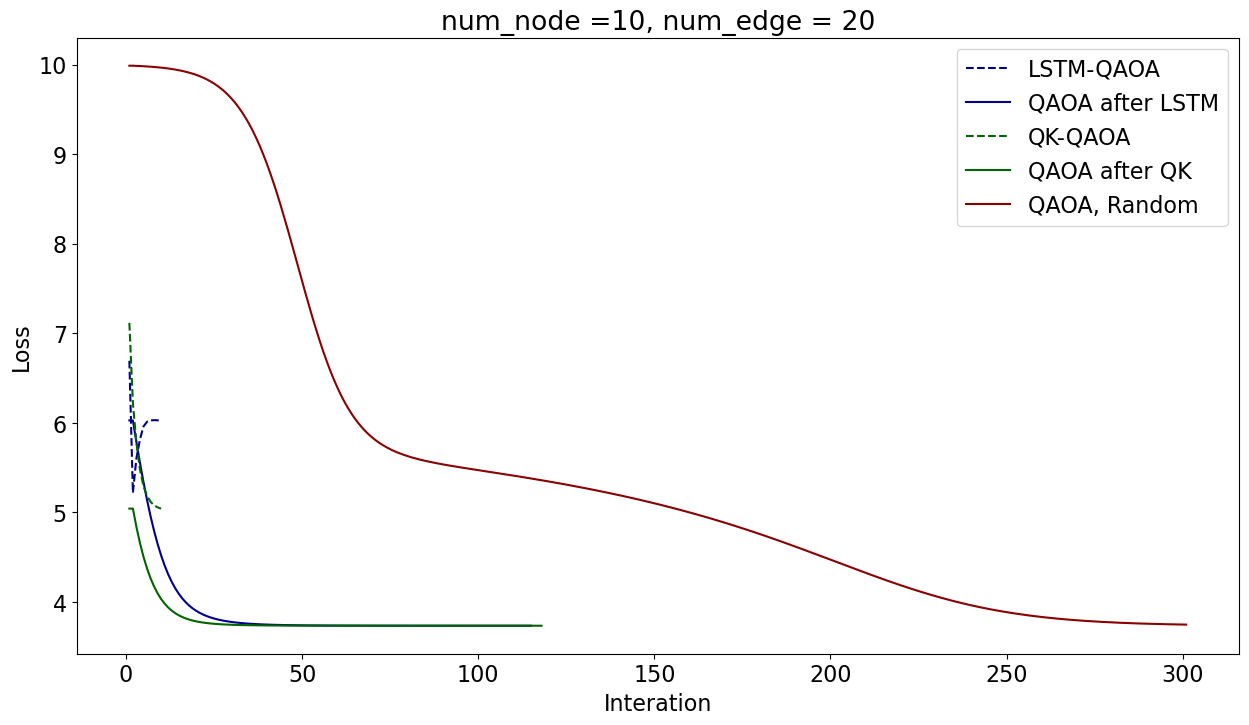


--- Starting LSTM Model Testing ---
LSTM predicted energies:[6.998771297566504, 5.191528407665522, 5.406169104389125, 5.611376051029572, 5.7795782977645125, 5.84919356314147, 5.871214902846117, 5.874332820088969, 5.872570059643831, 5.870574032565154]
LSTM predicted params:tensor([0.2929, 0.4448, 0.7632, 0.4723])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.77397920 Ha
Step = 100/300, Energy = 3.77171103 Ha
  Convergence reached at step 116
Optimization finished, final energy: 3.77168389 Ha

--- Starting QK Model Testing ---
QK predicted energies:[7.3235710241812475, 6.115073804517664, 5.5520482059922704, 5.222099657504285, 5.034693854799296, 4.92790040363324, 4.8661764576788915, 4.830159853602315, 4.809144595189792, 4.797022656080361]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.77190873 Ha
  Convergence reached at s

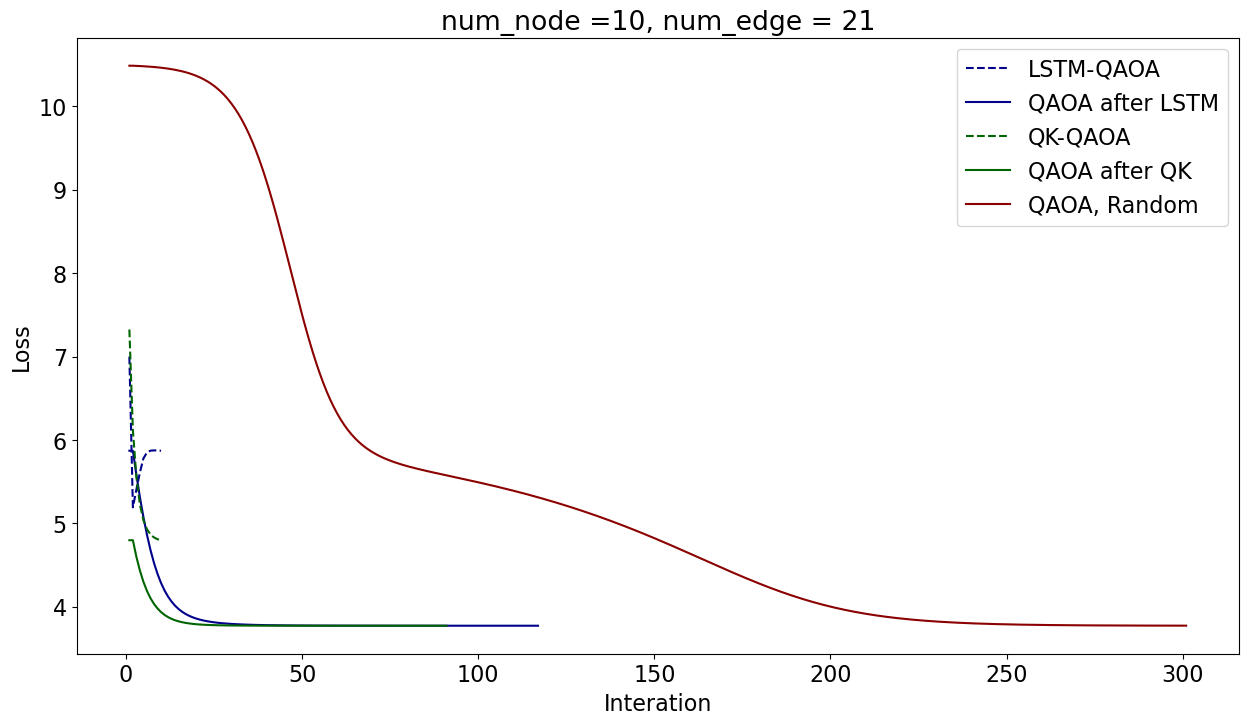


--- Starting LSTM Model Testing ---
LSTM predicted energies:[9.079881805656523, 6.246690992987474, 5.257928531167896, 5.065965135943515, 5.170560452133818, 5.268023653513363, 5.320828426296552, 5.341238703037752, 5.346271204966917, 5.345995159075286]
LSTM predicted params:tensor([0.3037, 0.4500, 0.7721, 0.4684])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.44515382 Ha
  Convergence reached at step 94
Optimization finished, final energy: 4.44452725 Ha

--- Starting QK Model Testing ---
QK predicted energies:[8.952504502230726, 6.437016533230654, 5.340961703173014, 4.893863284660184, 4.722538659298766, 4.658488153445645, 4.635236910896025, 4.62743685679105, 4.6254462381570365, 4.625578410879696]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.44468895 Ha
  Convergence reached at step 79
Optimization finished, final energy

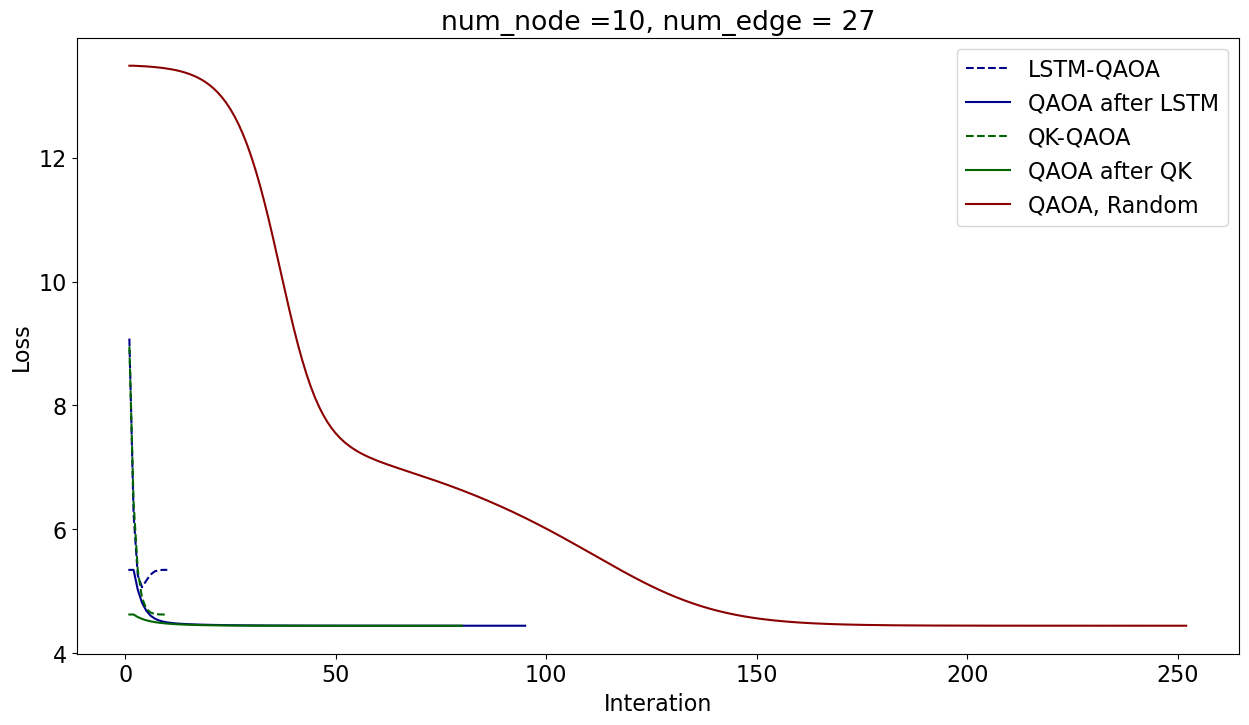


--- Starting LSTM Model Testing ---
LSTM predicted energies:[11.094536570213839, 7.508746634675138, 5.135784211950988, 4.88117179533779, 4.85569393504864, 4.837736715140354, 4.836034161230602, 4.836749727105168, 4.8373988922125415, 4.837918803511853]
LSTM predicted params:tensor([0.3138, 0.4550, 0.7789, 0.4636])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.56055915 Ha
  Convergence reached at step 82
Optimization finished, final energy: 4.56020433 Ha

--- Starting QK Model Testing ---
QK predicted energies:[10.035094594658826, 6.067869873479152, 5.03063249141942, 5.0472244335545655, 5.29439941878488, 5.528373775739947, 5.701888544609797, 5.819967855880098, 5.897142918937661, 5.946434639013828]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.56027093 Ha
  Convergence reached at step 69
Optimization finished, final energy

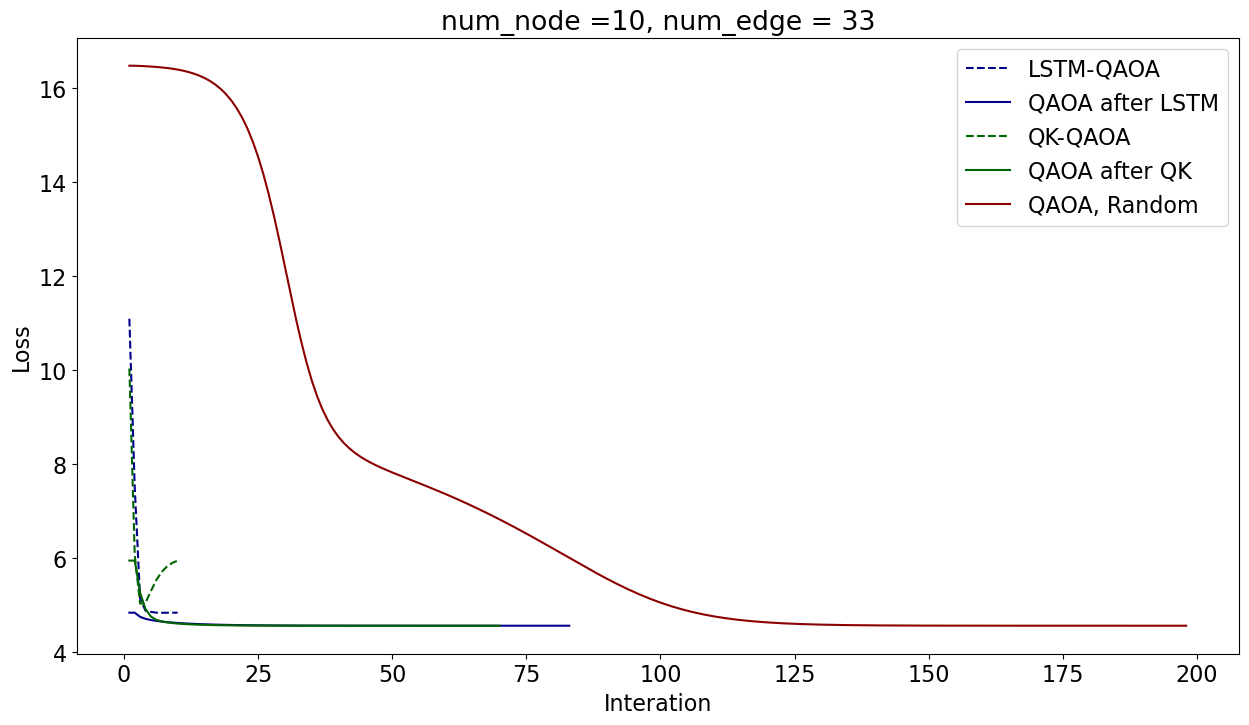


--- Starting LSTM Model Testing ---
LSTM predicted energies:[12.053067555917377, 8.386384579027458, 5.765983467664166, 5.771737310612971, 5.580968520186348, 5.484189588327861, 5.4603524440373805, 5.442729192861313, 5.434501657035345, 5.430950645019831]
LSTM predicted params:tensor([0.3018, 0.4491, 0.7699, 0.4692])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.73602058 Ha
  Convergence reached at step 76
Optimization finished, final energy: 4.73588461 Ha

--- Starting QK Model Testing ---
QK predicted energies:[10.56940222323998, 6.350748004687787, 5.72013474188029, 6.112890966279633, 6.608397497940356, 6.994586540781118, 7.260204106077405, 7.434133425352115, 7.545277087026196, 7.6152182281482474]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.73588228 Ha
  Convergence reached at step 51
Optimization finished, final ener

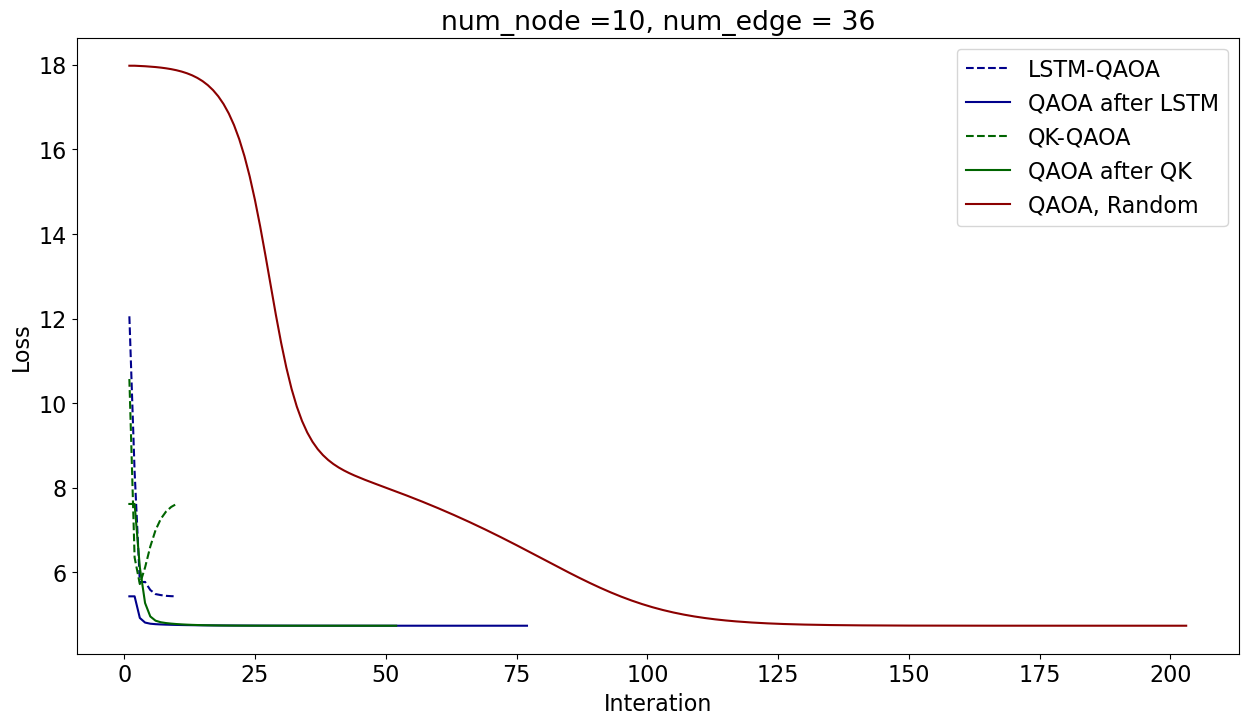


--- Starting LSTM Model Testing ---
LSTM predicted energies:[14.172383109185754, 10.768558297703414, 8.33350072350406, 9.572810358716973, 8.86222737057083, 8.921254870258393, 8.87964777931076, 8.830564050181637, 8.827942176010573, 8.814391581072709]
LSTM predicted params:tensor([0.2355, 0.4194, 0.7094, 0.4662])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.32764590 Ha
Step = 100/300, Energy = 4.32393599 Ha
  Convergence reached at step 109
Optimization finished, final energy: 4.32392270 Ha

--- Starting QK Model Testing ---
QK predicted energies:[11.626827033477696, 7.849309310805625, 8.88863785088163, 10.376876148652013, 11.465043513112775, 12.16780473884834, 12.609446940407718, 12.886446530101955, 13.06081738145089, 13.170965632460101]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.32701707 Ha
Step = 100/300, Energy =

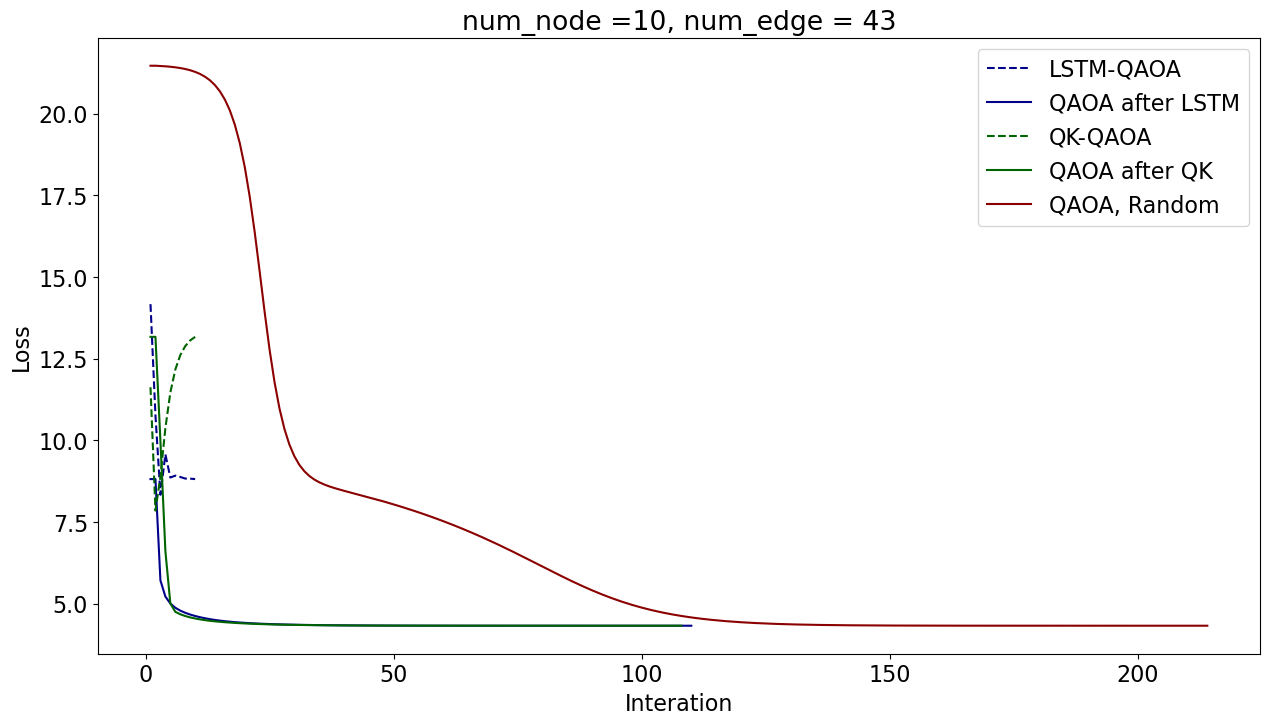


--- Starting LSTM Model Testing ---
LSTM predicted energies:[6.423545989010677, 5.380573468999218, 5.959526431131742, 6.182042873565208, 6.304109531160892, 6.343769182555314, 6.354865961655816, 6.3564241510095965, 6.355827588567748, 6.355095475479557]
LSTM predicted params:tensor([0.2829, 0.4403, 0.7544, 0.4746])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.86841831 Ha
Step = 100/300, Energy = 3.84871971 Ha
  Convergence reached at step 146
Optimization finished, final energy: 3.84838638 Ha

--- Starting QK Model Testing ---
QK predicted energies:[6.959636002435338, 6.416531609903742, 6.121669094694956, 5.892967415206604, 5.746645905562282, 5.657499762085764, 5.603617550454221, 5.571109050632608, 5.551603816440712, 5.54004574848029]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 3.85355498 Ha
Step = 100/300, Energy = 3.8

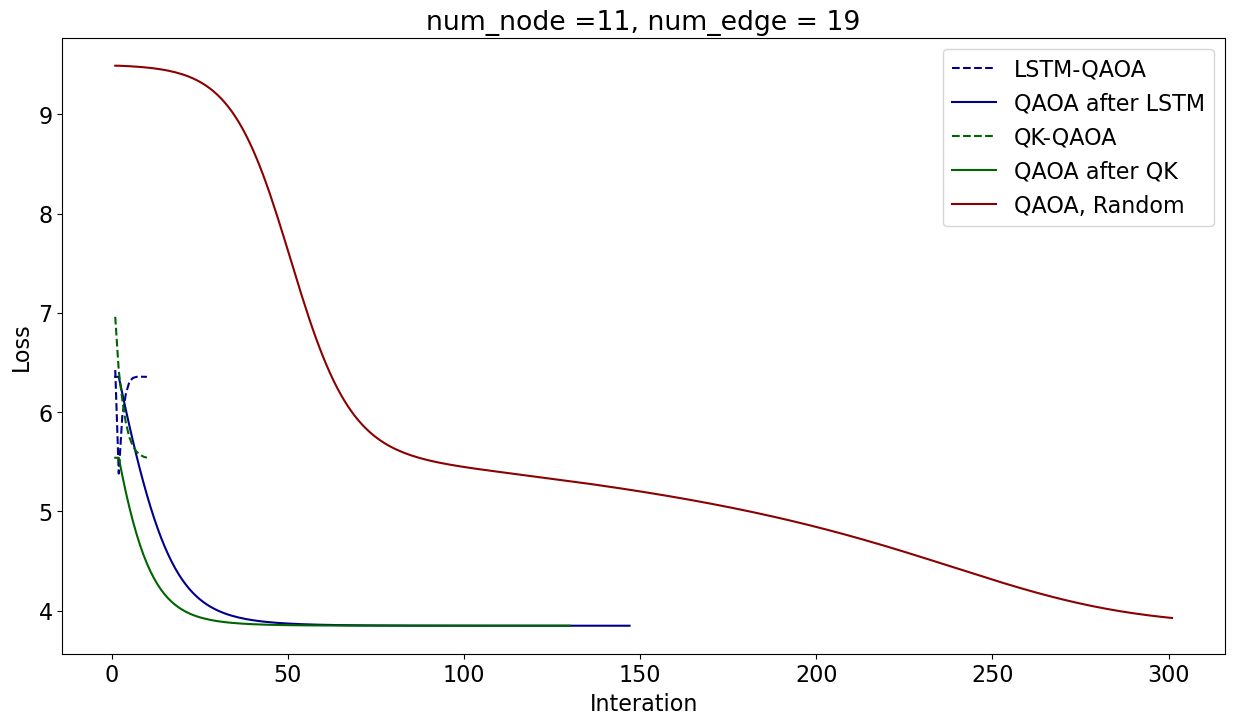


--- Starting LSTM Model Testing ---
LSTM predicted energies:[8.106146540342271, 6.344971623055718, 6.553680219242452, 6.712872035259707, 6.873114285126854, 6.942789098951826, 6.967028073638553, 6.972313030792208, 6.972207718491023, 6.97128476862201]
LSTM predicted params:tensor([0.2704, 0.4346, 0.7428, 0.4758])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.65877635 Ha
  Convergence reached at step 95
Optimization finished, final energy: 4.65757000 Ha

--- Starting QK Model Testing ---
QK predicted energies:[8.50399990128759, 7.235371498464868, 6.607230851905345, 6.243805605766009, 6.043895126477319, 5.933102834108239, 5.870406890087096, 5.834407354972486, 5.813684355041187, 5.801893312983192]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.65780374 Ha
  Convergence reached at step 88
Optimization finished, final energy: 

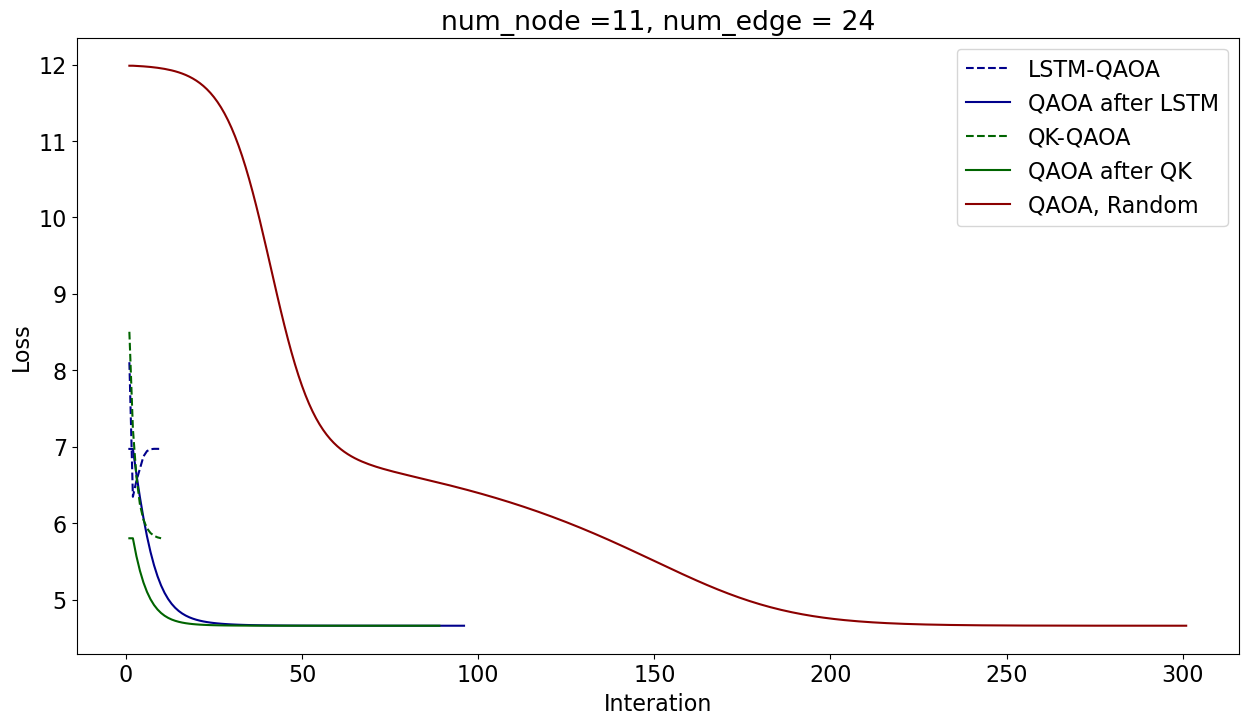


--- Starting LSTM Model Testing ---
LSTM predicted energies:[9.486882580904464, 7.013798572105987, 6.3503718583276605, 6.2059489100218626, 6.3176508863207035, 6.411859762975608, 6.460749140160358, 6.478508078809394, 6.482443457257296, 6.482019088849375]
LSTM predicted params:tensor([0.2804, 0.4391, 0.7522, 0.4749])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.15029843 Ha
  Convergence reached at step 93
Optimization finished, final energy: 5.14975909 Ha

--- Starting QK Model Testing ---
QK predicted energies:[9.52138557248699, 7.302466393231967, 6.293470321376537, 5.839914031642138, 5.643335996439164, 5.55641385754003, 5.516508527528271, 5.497568774499178, 5.488459858570369, 5.484186914961604]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.14999127 Ha
  Convergence reached at step 84
Optimization finished, final energ

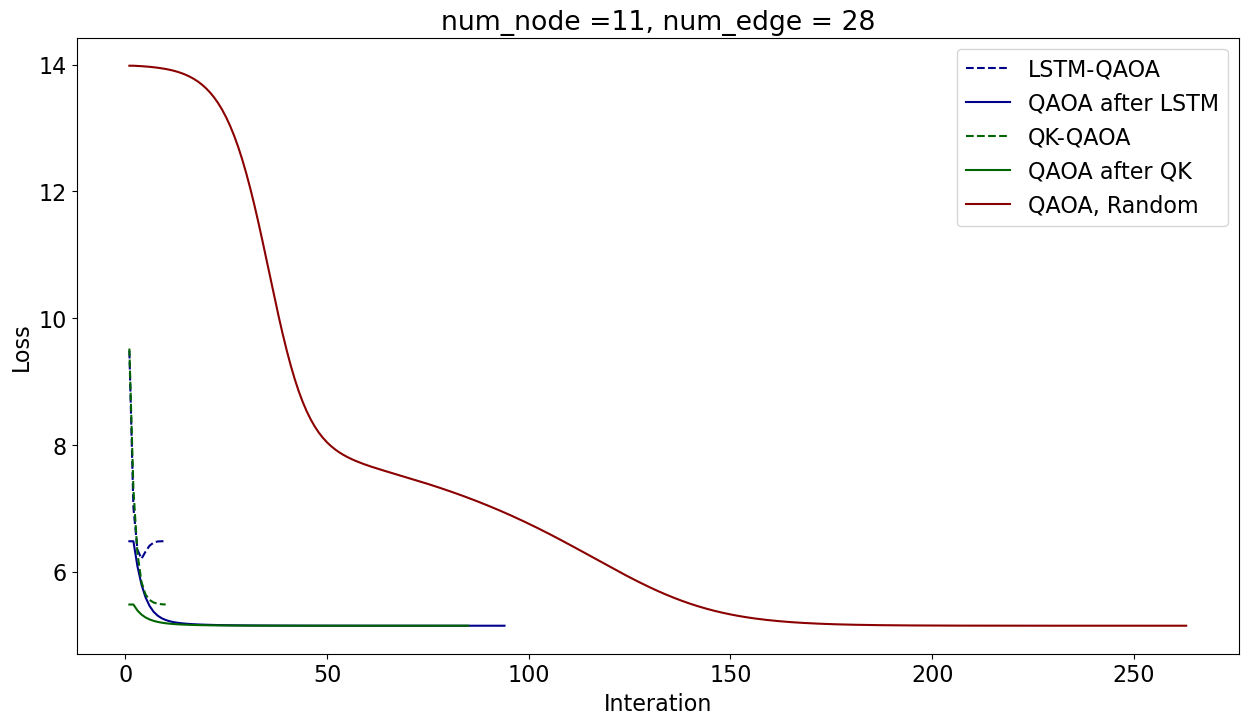


--- Starting LSTM Model Testing ---
LSTM predicted energies:[10.554551737722804, 7.739749852373164, 6.450848862033898, 6.019476070738404, 6.036393046984464, 6.1131588045815874, 6.166020920773378, 6.1903832346389756, 6.198621026241602, 6.200230873251566]
LSTM predicted params:tensor([0.2863, 0.4418, 0.7575, 0.4739])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.46520831 Ha
  Convergence reached at step 84
Optimization finished, final energy: 5.46493174 Ha

--- Starting QK Model Testing ---
QK predicted energies:[10.296267946037046, 7.461270088993267, 6.274427912809621, 5.830554400712568, 5.684957538056099, 5.645054856102387, 5.639528739784743, 5.643612939198269, 5.64923752023561, 5.654110325849488]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.46499012 Ha
  Convergence reached at step 69
Optimization finished, final ene

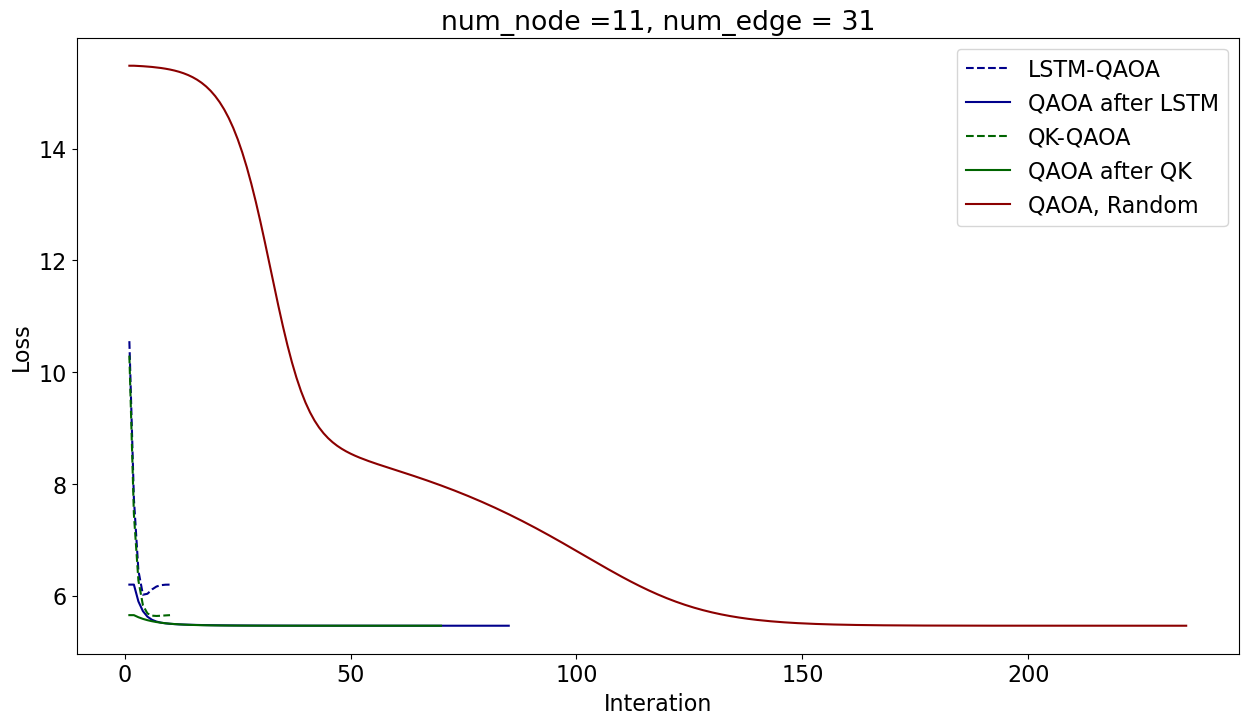


--- Starting LSTM Model Testing ---
LSTM predicted energies:[12.721371042407178, 9.375951597016403, 6.947028041587715, 6.206390387092243, 6.1334868950692565, 6.133971899724247, 6.140412413226011, 6.144552697133155, 6.146498407281126, 6.147330960990635]
LSTM predicted params:tensor([0.2873, 0.4423, 0.7580, 0.4735])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.07193302 Ha
  Convergence reached at step 73
Optimization finished, final energy: 6.07181775 Ha

--- Starting QK Model Testing ---
QK predicted energies:[11.699304576850517, 7.705478083640981, 6.6103223331533405, 6.587176273731309, 6.806685053939262, 7.0206180032300916, 7.180058547565464, 7.288688465464532, 7.359778185026585, 7.405302225063102]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.07182386 Ha
  Convergence reached at step 55
Optimization finished, final e

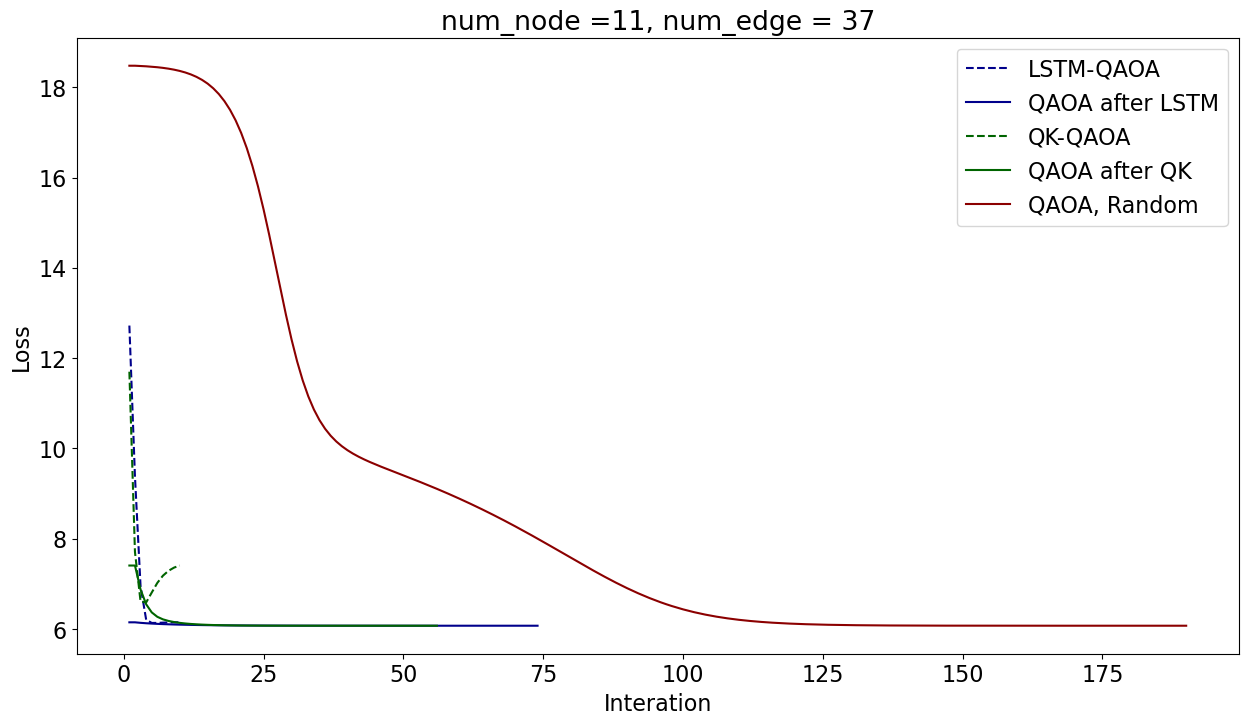


--- Starting LSTM Model Testing ---
LSTM predicted energies:[14.718194165230127, 11.149160938489901, 8.15830692075927, 7.993850137648033, 7.841795112519472, 7.694208537628242, 7.6526159129112425, 7.623849802049644, 7.607905634397465, 7.60042168763605]
LSTM predicted params:tensor([0.2580, 0.4293, 0.7303, 0.4739])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
  Convergence reached at step 46
Optimization finished, final energy: 6.13191008 Ha

--- Starting QK Model Testing ---
QK predicted energies:[12.58914292810522, 8.032695269379586, 7.877187912902681, 8.691965897177198, 9.437360545380816, 9.961520857879565, 10.304791768265872, 10.524338915671029, 10.663452502362192, 10.751150547146471]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.13191117 Ha
  Convergence reached at step 51
Optimization finished, final energy: 6.13191019 Ha

--- Standard QAO

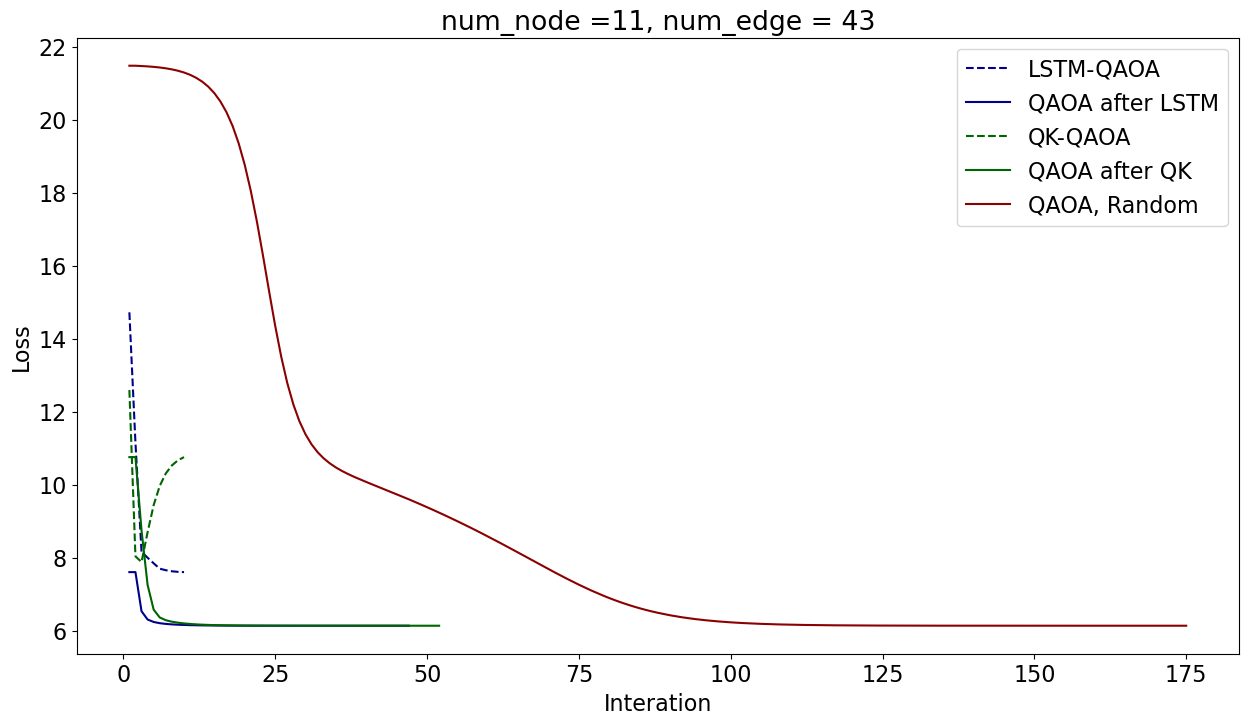


--- Starting LSTM Model Testing ---
LSTM predicted energies:[16.402373657023, 12.852284401681468, 9.96319957673172, 10.478025079398732, 10.176675168297384, 10.034988739714025, 10.011734277648712, 9.957723624768006, 9.93770340797773, 9.924195270322457]
LSTM predicted params:tensor([0.2172, 0.4112, 0.6934, 0.4520])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.27076626 Ha
  Convergence reached at step 82
Optimization finished, final energy: 6.27037368 Ha

--- Starting QK Model Testing ---
QK predicted energies:[13.469042726251551, 9.36540424126691, 10.358254019113769, 11.815665095087585, 12.85001763093175, 13.50071862606086, 13.902375241658014, 14.151668632312088, 14.307874188955275, 14.406538538800156]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.27060288 Ha
  Convergence reached at step 78
Optimization finished, final

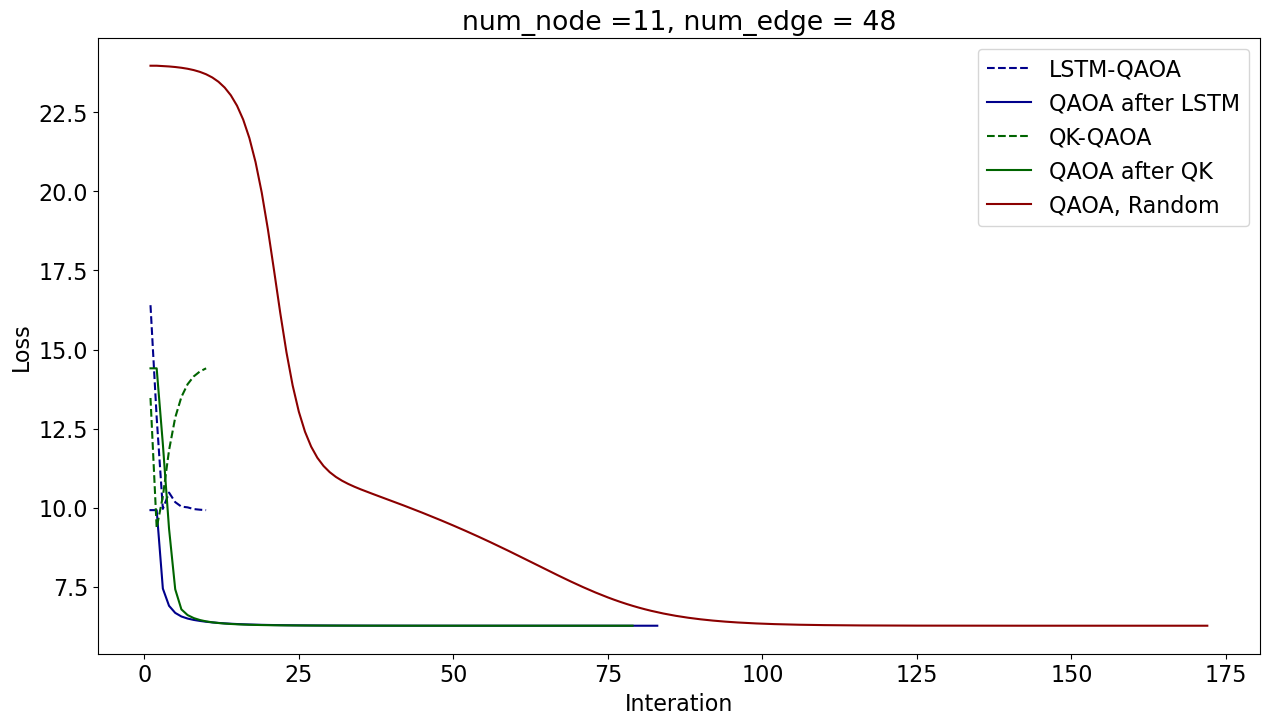


--- Starting LSTM Model Testing ---
LSTM predicted energies:[17.573098067578766, 14.210857502772962, 11.687645097929128, 12.685227964688545, 12.176234937065098, 12.134712684891184, 12.103376552195765, 12.034941206434342, 12.020452549318316, 11.998010538560477]
LSTM predicted params:tensor([0.1875, 0.3974, 0.6731, 0.4133])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.80651059 Ha
Step = 100/300, Energy = 5.79977519 Ha
  Convergence reached at step 112
Optimization finished, final energy: 5.79975364 Ha

--- Starting QK Model Testing ---
QK predicted energies:[14.12348900593934, 10.906685388575747, 12.782808387494281, 14.583983866464793, 15.719613703552573, 16.389978033904836, 16.788778961515707, 17.03154364918475, 17.182622106154497, 17.278294294659933]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.80350798 Ha
Step = 100

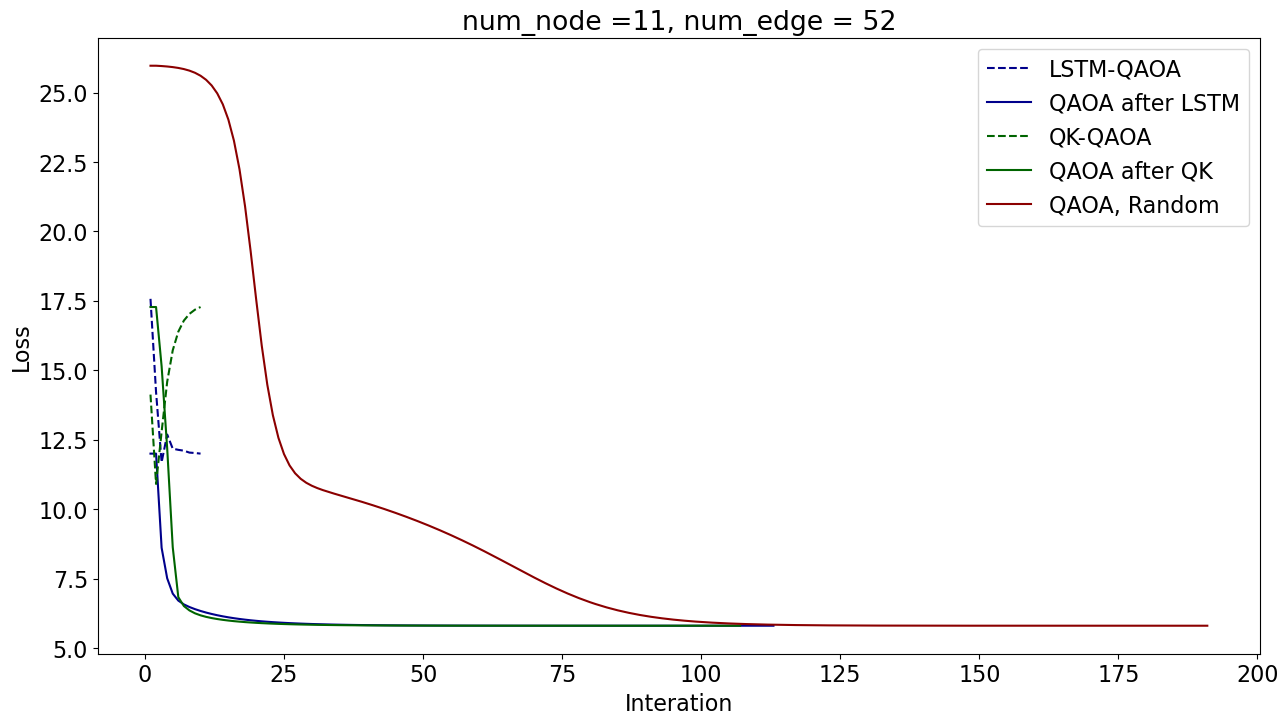


--- Starting LSTM Model Testing ---
LSTM predicted energies:[6.6895797661728285, 5.714935824132061, 6.492980102696773, 6.756441996864091, 6.886628526579087, 6.924996605584792, 6.935403318300567, 6.937072334308904, 6.9368734020101215, 6.936486948749887]
LSTM predicted params:tensor([0.2711, 0.4349, 0.7434, 0.4758])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.11264530 Ha
Step = 100/300, Energy = 4.05494236 Ha
Step = 150/300, Energy = 4.05306999 Ha
  Convergence reached at step 174
Optimization finished, final energy: 4.05301363 Ha

--- Starting QK Model Testing ---
QK predicted energies:[7.291992453011826, 6.790728816497309, 6.5944919360536725, 6.424696287566594, 6.309525399219127, 6.237198437114085, 6.192760703116383, 6.165743243022778, 6.149520310480718, 6.139968414241759]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 

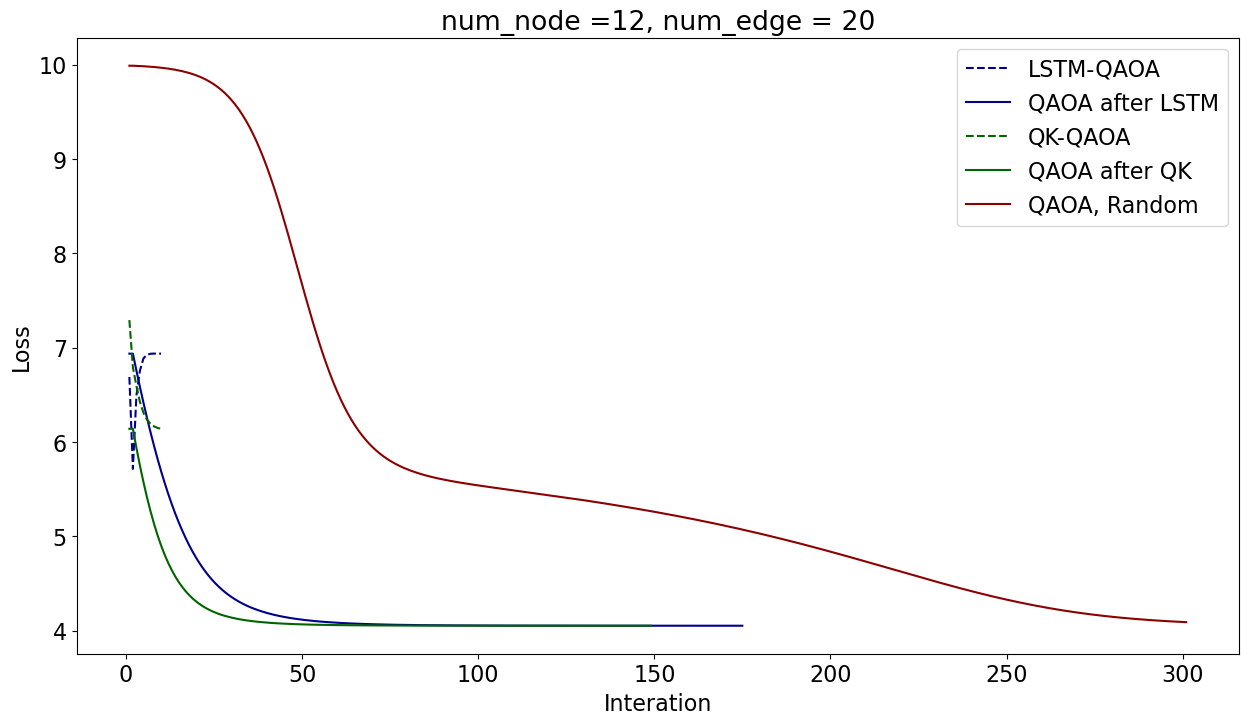


--- Starting LSTM Model Testing ---
LSTM predicted energies:[8.03243254028103, 6.44644717019876, 6.911134879070067, 7.147137827994637, 7.316252198552884, 7.378536677179927, 7.39776170083814, 7.401467112230949, 7.40139632992688, 7.400860189938972]
LSTM predicted params:tensor([0.2619, 0.4309, 0.7347, 0.4754])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.84296751 Ha
Step = 100/300, Energy = 4.83558118 Ha
  Convergence reached at step 123
Optimization finished, final energy: 4.83551451 Ha

--- Starting QK Model Testing ---
QK predicted energies:[8.479991559080794, 7.364785268757391, 6.901669465524903, 6.6220347884319715, 6.460167635147936, 6.367076356244398, 6.31307257598775, 6.281585871353129, 6.263323503583921, 6.252928905144554]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 4.83739936 Ha
Step = 100/300, Energy = 4.83556

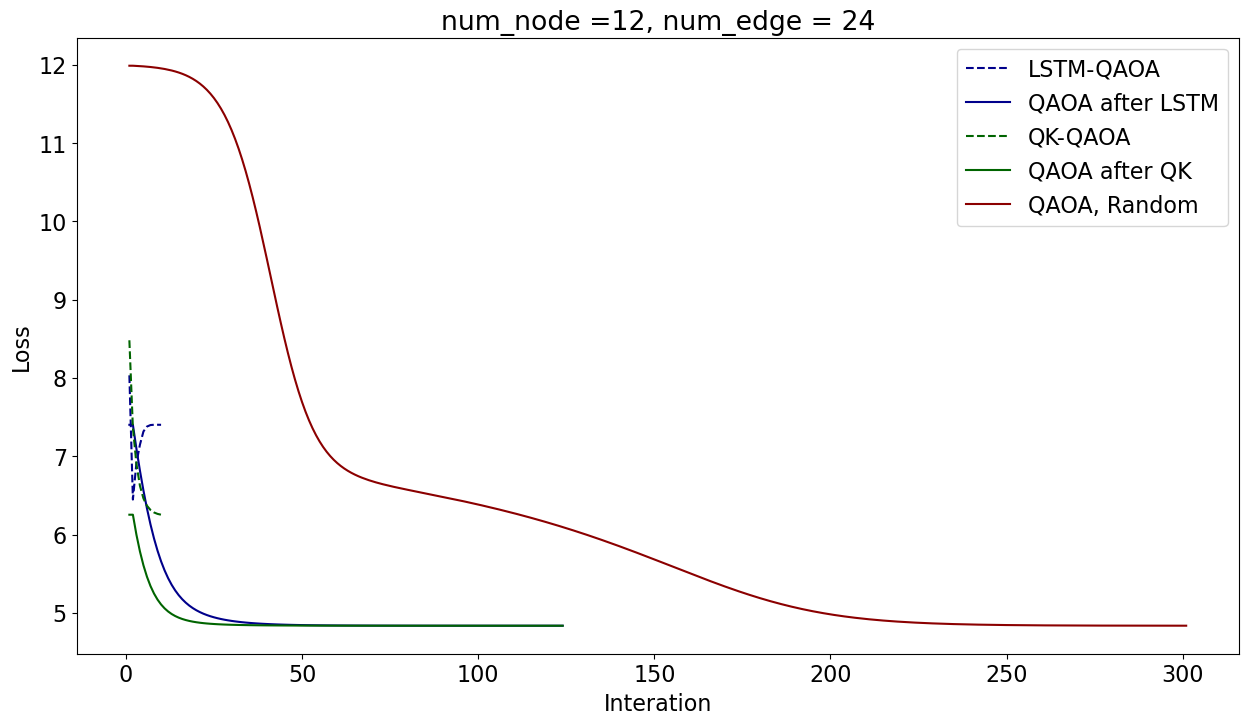


--- Starting LSTM Model Testing ---
LSTM predicted energies:[10.318407438126815, 7.917006279934036, 7.147582899085251, 6.909313603130499, 6.990615143756319, 7.083257126592649, 7.13757330826375, 7.16062260873492, 7.168098366720786, 7.169660263274915]
LSTM predicted params:tensor([0.2666, 0.4330, 0.7392, 0.4756])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.83857247 Ha
  Convergence reached at step 92
Optimization finished, final energy: 5.83790295 Ha

--- Starting QK Model Testing ---
QK predicted energies:[10.296578938248565, 7.96381487500704, 6.905986007998199, 6.464825671700886, 6.294148753444383, 6.229766108490336, 6.206317011175229, 6.19868142215707, 6.197148919427455, 6.197902908199895]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 5.83835771 Ha
  Convergence reached at step 89
Optimization finished, final energy: 

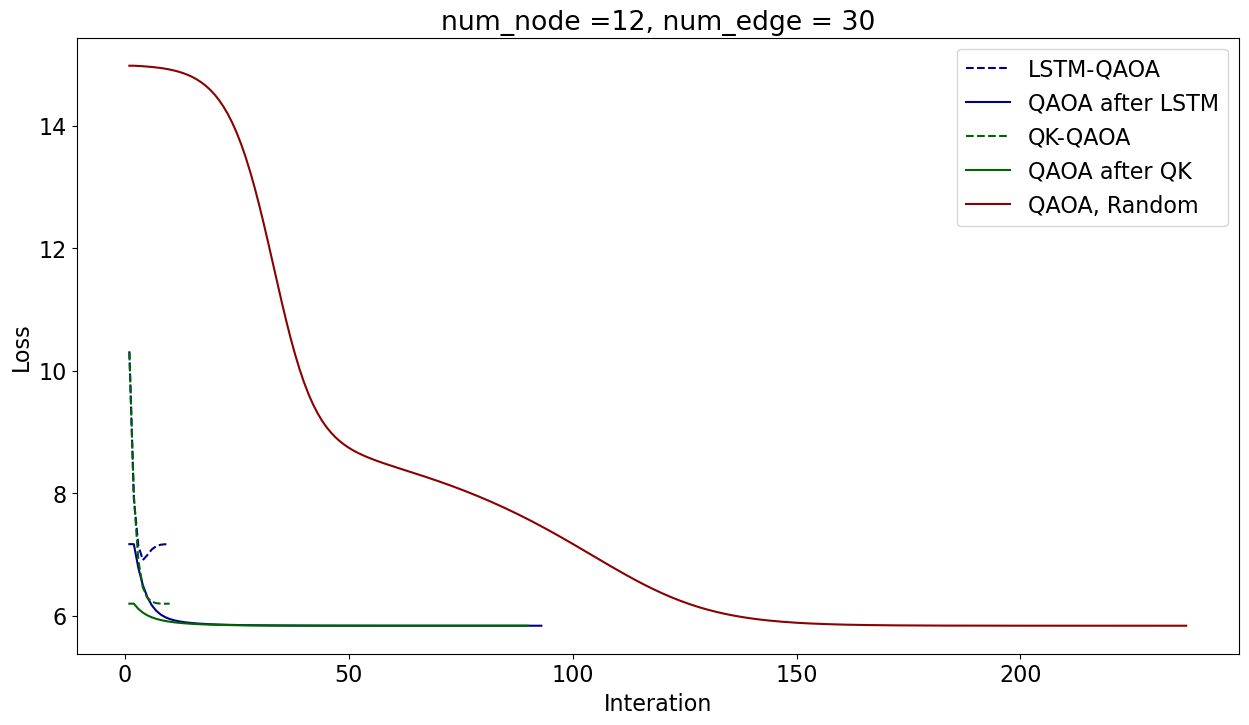


--- Starting LSTM Model Testing ---
LSTM predicted energies:[10.653880968248425, 8.177366034604109, 7.301719278630254, 7.017846722689991, 7.092374295278241, 7.189339549835865, 7.248118110478301, 7.27380102422446, 7.2825107887187785, 7.2845763842494975]
LSTM predicted params:tensor([0.2644, 0.4320, 0.7371, 0.4755])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.02652614 Ha
  Convergence reached at step 93
Optimization finished, final energy: 6.02576383 Ha

--- Starting QK Model Testing ---
QK predicted energies:[10.568582286843235, 8.068307971719856, 6.98532996921256, 6.565019393981379, 6.419175465788593, 6.374048375291063, 6.363882473845228, 6.364992184716462, 6.369089174001752, 6.373421393333228]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.02632587 Ha
  Convergence reached at step 90
Optimization finished, final ener

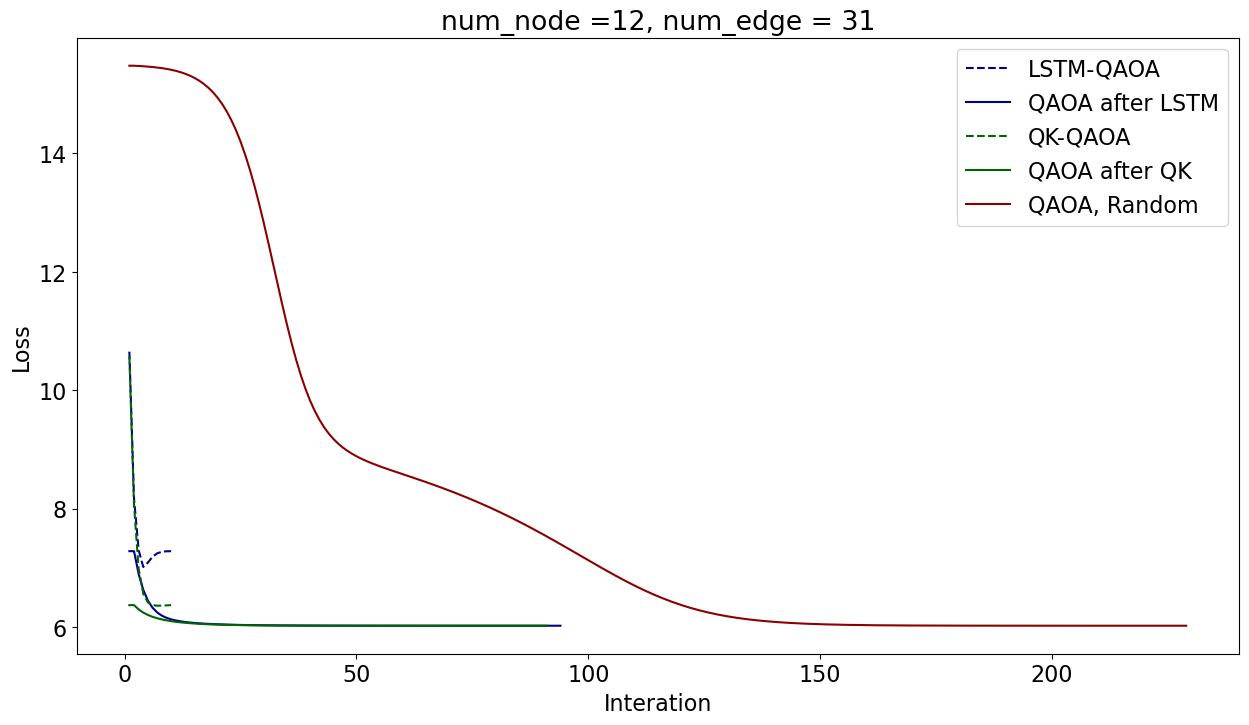


--- Starting LSTM Model Testing ---
LSTM predicted energies:[12.862026620266631, 9.966229495727868, 8.087041283135843, 7.187728059063698, 7.036762715628575, 7.075738975213373, 7.126837858790574, 7.157098878800308, 7.170987368870458, 7.176443444912642]
LSTM predicted params:tensor([0.2667, 0.4330, 0.7391, 0.4754])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.75932280 Ha
  Convergence reached at step 72
Optimization finished, final energy: 6.75919861 Ha

--- Starting QK Model Testing ---
QK predicted energies:[12.206571240755213, 8.590837518604685, 7.301309577656762, 7.0282321998271104, 7.065907089250092, 7.162971108567421, 7.250052232580374, 7.314500576445433, 7.358861778520956, 7.388397111436895]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.75925112 Ha
  Convergence reached at step 66
Optimization finished, final ene

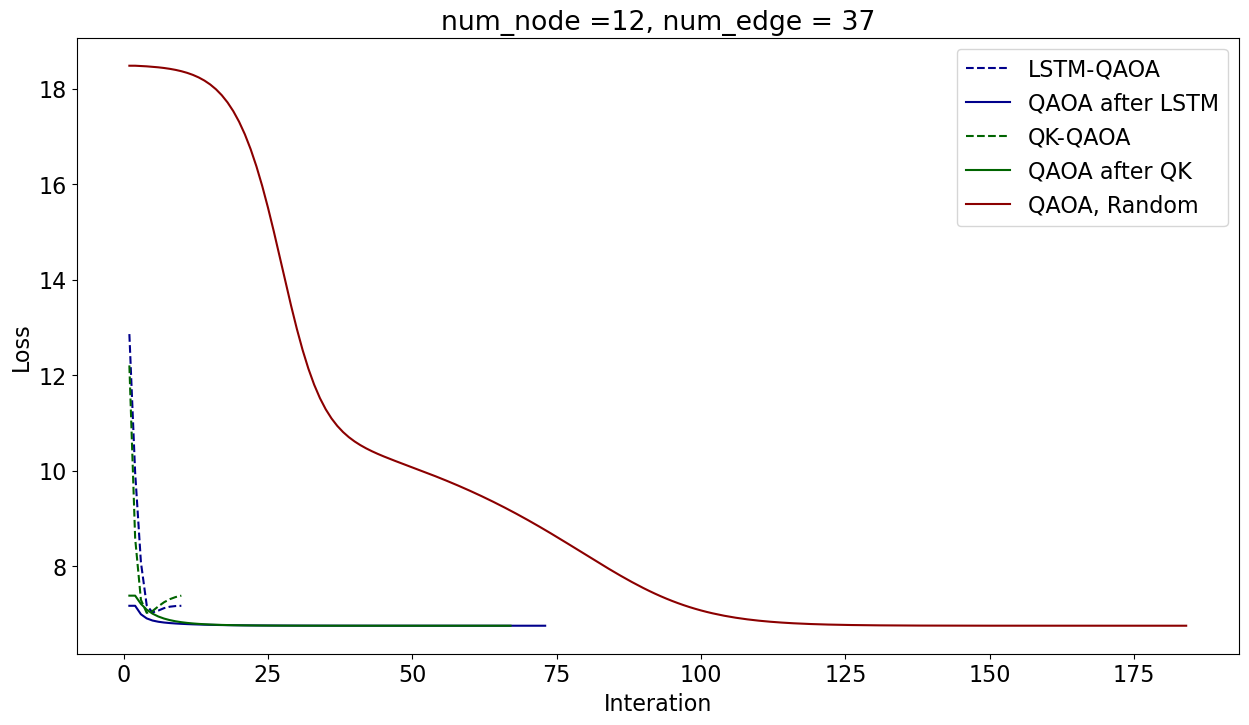


--- Starting LSTM Model Testing ---
LSTM predicted energies:[16.07808135607819, 12.751652133369866, 9.927135633365415, 8.864106949578847, 8.679008850962546, 8.551279609403423, 8.48278412769364, 8.45262132568736, 8.43620908768286, 8.427502902503697]
LSTM predicted params:tensor([0.2426, 0.4226, 0.7156, 0.4689])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
  Convergence reached at step 49
Optimization finished, final energy: 7.44564337 Ha

--- Starting QK Model Testing ---
QK predicted energies:[13.964288024582814, 9.192663795997747, 8.828855636189665, 9.555013651605076, 10.263036065295982, 10.770671300365526, 11.106485176437225, 11.322740397241542, 11.460559791916427, 11.547947796531021]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
  Convergence reached at step 48
Optimization finished, final energy: 7.44564186 Ha

--- Standard QAOA, random params ---

--- Starting VQE

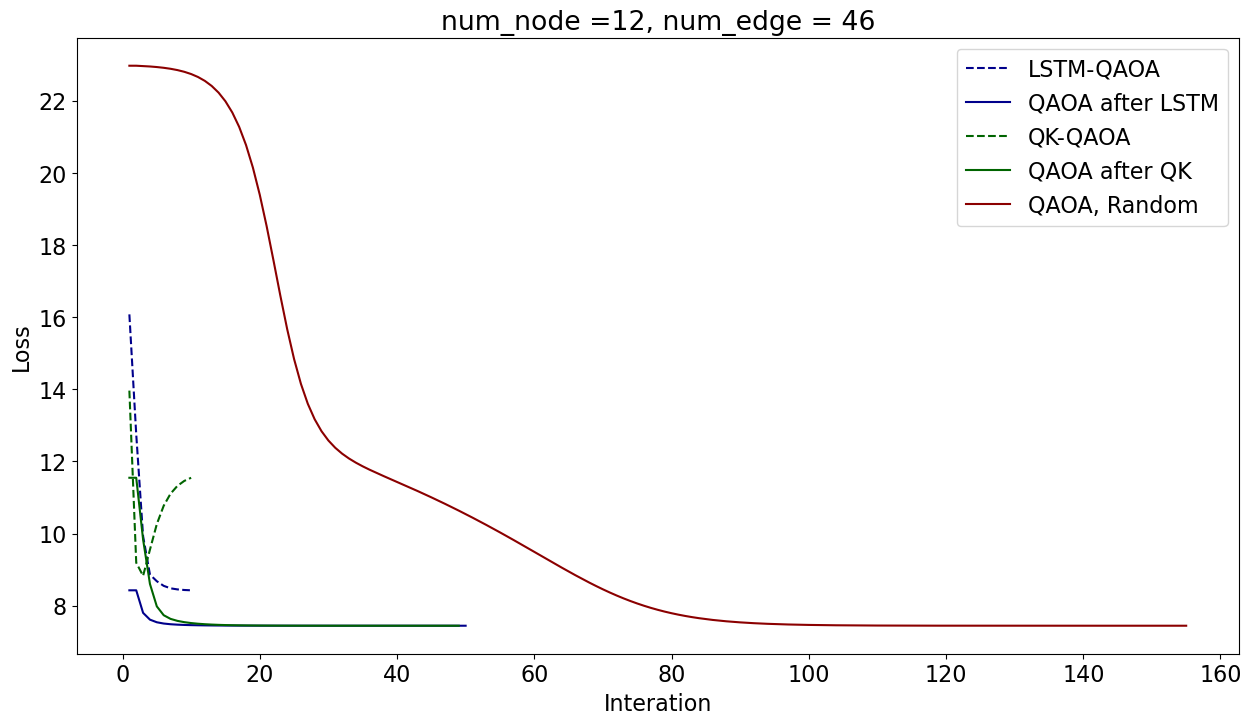


--- Starting LSTM Model Testing ---
LSTM predicted energies:[18.598179123869297, 15.154962242341053, 12.451265234618544, 11.756891743096629, 11.617374385975861, 11.406144939463559, 11.29459048182177, 11.228793345481522, 11.182294792599782, 11.154009249462325]
LSTM predicted params:tensor([0.1991, 0.4030, 0.6797, 0.4289])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.91915532 Ha
  Convergence reached at step 70
Optimization finished, final energy: 7.91904054 Ha

--- Starting QK Model Testing ---
QK predicted energies:[15.316176400851884, 10.9322441140946, 11.929592015347472, 13.414939105635815, 14.456682172016151, 15.106646676793552, 15.505938205420845, 15.753063013310724, 15.907639828872773, 16.005180354011372]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.91906892 Ha
  Convergence reached at step 62
Optimization finis

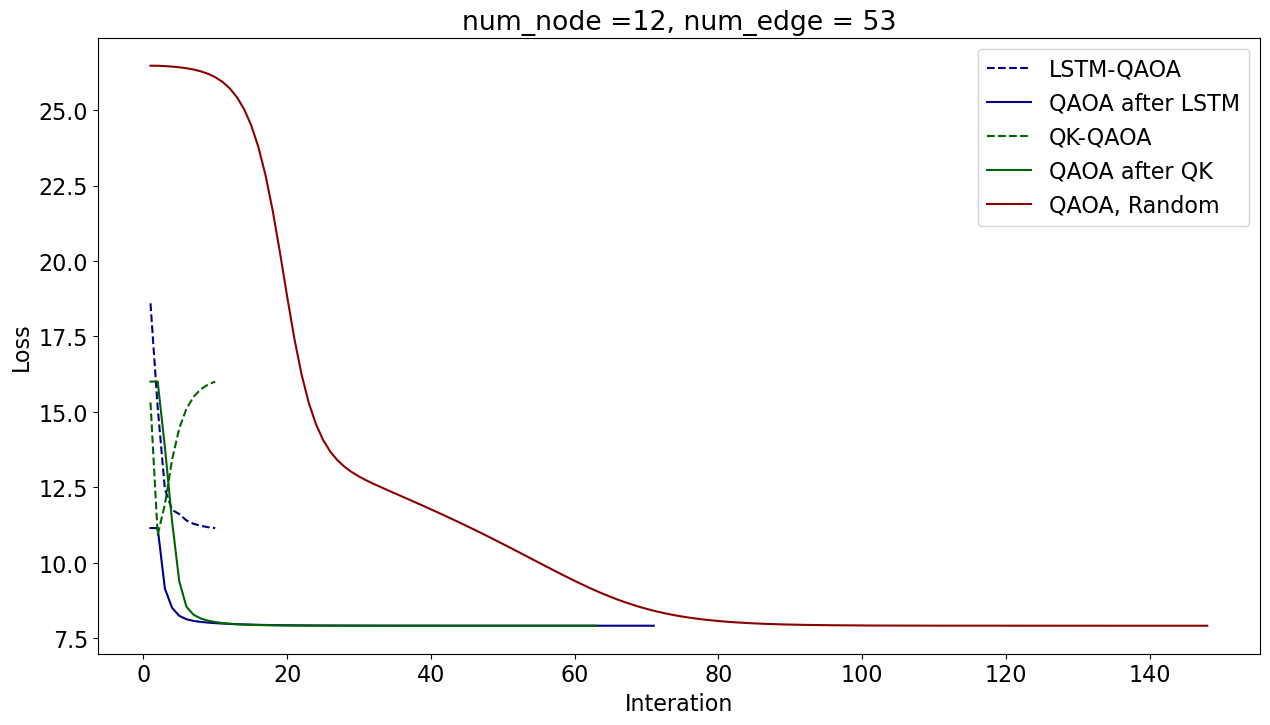


--- Starting LSTM Model Testing ---
LSTM predicted energies:[20.26854324627479, 16.79365600331605, 14.46286449792873, 14.24387483659245, 14.145380464915496, 13.952793396313997, 13.851347543684914, 13.774636937746246, 13.715050347555936, 13.673575069323563]
LSTM predicted params:tensor([0.1674, 0.3876, 0.6637, 0.3709])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.93962994 Ha
  Convergence reached at step 84
Optimization finished, final energy: 7.93875022 Ha

--- Starting QK Model Testing ---
QK predicted energies:[16.245842318609895, 12.81129706820584, 14.749839368131333, 16.55865053920212, 17.666421735389363, 18.307195022803707, 18.683126988840545, 18.909612829591556, 19.04936295875681, 19.13719357843186]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.93905631 Ha
  Convergence reached at step 77
Optimization finished, 

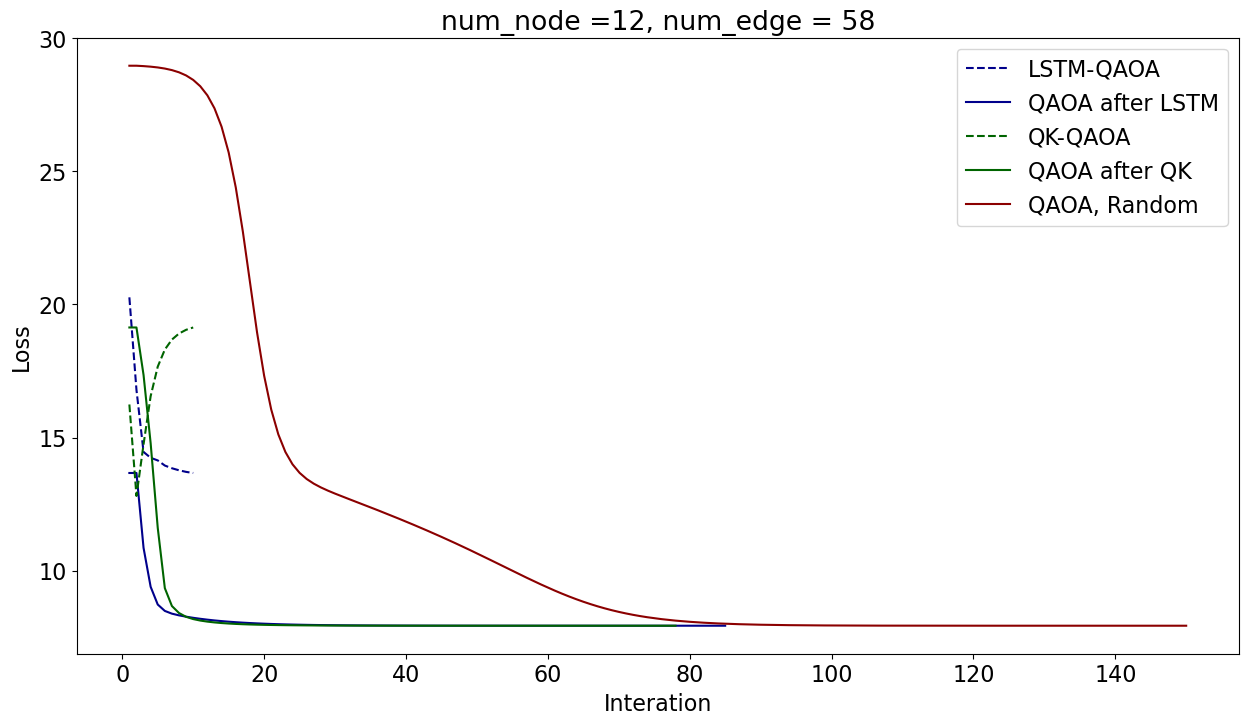


--- Starting LSTM Model Testing ---
LSTM predicted energies:[21.47384161171638, 18.024590723425355, 16.110291821850424, 16.327468378263212, 16.346980141290604, 16.277441358006765, 16.25778798793683, 16.236780275052585, 16.216999108614008, 16.20169700832647]
LSTM predicted params:tensor([0.1410, 0.3731, 0.6585, 0.3093])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.54898583 Ha
Step = 100/300, Energy = 7.54419522 Ha
  Convergence reached at step 100
Optimization finished, final energy: 7.54419522 Ha

--- Starting QK Model Testing ---
QK predicted energies:[17.045699842984106, 14.656197015840291, 17.243004418321537, 19.24844781717526, 20.39020551191317, 21.02029032767947, 21.37799435817368, 21.588563897312785, 21.71641515333127, 21.795897789922442]
QK predicted params:tensor([0.3687, 0.4839, 0.7427, 0.4068])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.54631598 Ha
  Convergence re

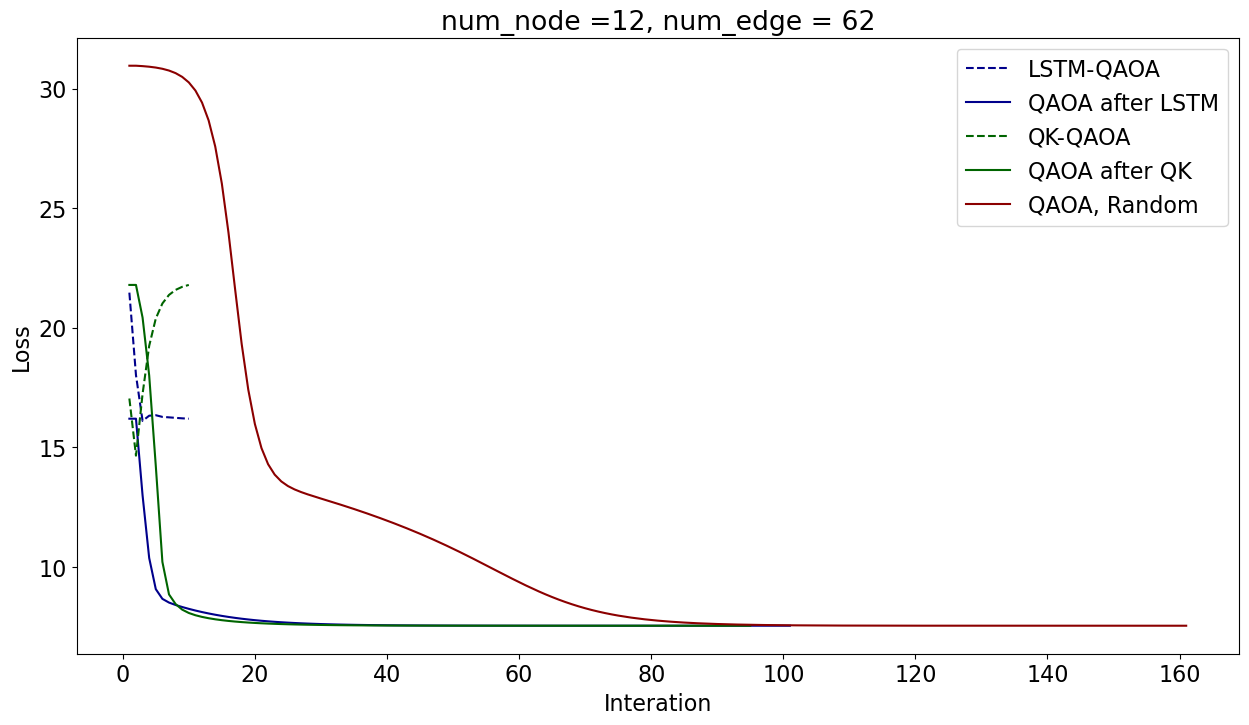


--- Simulation Complete ---


In [10]:
"""
Model Testing
"""
# --- Model Evaluating ---
print(f"\n--- Evaluating Model ---")

#params_rand = torch.rand(input_feature_dim, dtype = torch.float32)
params_rand = torch.tensor([0.01,0.01,0.01,0.01])

for i in range(len(test_set)):
        graph_test_result = {}
        # predicted by model
        lstm_predicted_params_list, lstm_predicted_energies_list = lstm_trainer.evaluate(
            graph_data = test_set[i],
            num_rnn_iteration = steps_recurrent_loop_test)

        print(f"{lstm_model.model_type} predicted energies:{lstm_predicted_energies_list}")
        print(f"{lstm_model.model_type} predicted params:{lstm_predicted_params_list[-1]}")
       
        # use LSTM/QK -FC output as initial params for QAOA to optimize
        print(f"\n--- QAOA optimization after model ---")
        lstm_qaoa = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  True)
        
        opt_lstm_qaoa = QAOA.QAOAptimizer(lstm_qaoa)
        conv_iter_lstm, final_params_lstm, final_energy_lstm, params_history_lstm, energy_history_lstm = opt_lstm_qaoa.run_optimization(
            initial_params = lstm_predicted_params_list[-1],
            optimizer = qaoa_optimizer,
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        
        # QK
        qk_predicted_params_list, qk_predicted_energies_list = qk_trainer.evaluate(
            graph_data = test_set[i],
            num_rnn_iteration = steps_recurrent_loop_test)

        print(f"{qk_model.model_type} predicted energies:{qk_predicted_energies_list}")
        print(f"{qk_model.model_type} predicted params:{qk_predicted_params_list[-1]}")

        # use LSTM/QK -FC output as initial params for QAOA to optimize
        print(f"\n--- QAOA optimization after model ---")
        qk_qaoa = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  True)
        
        opt_qk_qaoa = QAOA.QAOAptimizer(qk_qaoa)
        conv_iter_qk, final_params_qk, final_energy_qk, params_history_qk, energy_history_qk = opt_qk_qaoa.run_optimization(
            initial_params = qk_predicted_params_list[-1],
            optimizer = qaoa_optimizer,
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        
        # QAOA predict without guess by LSTM/QK
        
        print(f"\n--- Standard QAOA, random params ---")
        # random params
        
        qaoa_test_rand = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_rand_qaoa = QAOA.QAOAptimizer(qaoa_test_rand)
        conv_iter_rand, final_params_rand, final_energy_rand, params_history_rand, energy_history_rand = opt_rand_qaoa.run_optimization(
            initial_params = params_rand,
            optimizer = "SGD",
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        """
        # params which all zeros
        print(f"\n--- Standard VQE, zero params ---")
        params_zeros = torch.zeros(input_feature_dim, dtype = torch.float32)
        qaoa_test_zeros = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_zeros_qaoa = QAOA.QAOAptimizer(qaoa_test_zeros)
        conv_iter_zeros, final_params_zeros, final_energy_zeros, params_history_zeros, energy_history_zeros = opt_zeros_qaoa.run_optimization(
            initial_params = params_zeros,
            optimizer = "SGD",
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )  
        
        print(f"\n--- Standard QAOA, pi params ---")
        params_pi = torch.ones(input_feature_dim,dtype = torch.float32) * math.pi
        qaoa_test_pi = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_pi_qaoa = QAOA.QAOAptimizer(qaoa_test_pi)
        conv_iter_pi, final_params_pi, final_energy_pi, params_history_pi, energy_history_pi = opt_pi_qaoa.run_optimization(
            initial_params = params_pi,
            optimizer = qaoa_optimizer,
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa)
        """
        # save result and output as csv
        # result to pd
        graph_test_result = {
            #'molecule': molecule_data.molname,
            #'bondlength': molecule_data.bondlength,
            'LSTM-QAOA': pd.Series(lstm_predicted_energies_list),
            'QAOA after LSTM':pd.Series(energy_history_lstm),
            'QK-QAOA': pd.Series(qk_predicted_energies_list),
            'QAOA after QK': pd.Series(energy_history_qk),
            'QAOA Random': pd.Series(energy_history_rand),
            #'VQE Zeros': pd.Series(energy_history_zeros),
            #'QAOA Pi': pd.Series(energy_history_pi)
            }
        
        df_result = pd.DataFrame(graph_test_result)
        df_result.to_csv(f"{Results_save_path}_node_{len(test_set[i].nodes)}_{i}_edge_{len(test_set[i].edges)}_{i}.csv", index = False)
        print("\n--- Saving Complete ---")
      
        print("Result of QAOA Optimization")
        plt.figure(figsize = (15,8))
        font = {'size':16}
        plt.rc('font', **font)
        plt.plot(range(1, len(lstm_predicted_energies_list) + 1), lstm_predicted_energies_list, label=f'LSTM-QAOA', color = "darkblue", ls="dashed", markersize = 9)
        plt.plot(range(1, len(energy_history_lstm) + 1), energy_history_lstm, label=f'QAOA after LSTM',  color = "darkblue", markersize = 9)
        plt.plot(range(1, len(qk_predicted_energies_list) + 1), qk_predicted_energies_list, label=f'QK-QAOA', ls="dashed", color = "darkgreen", markersize = 9)
        plt.plot(range(1, len(energy_history_qk) + 1), energy_history_qk, label=f'QAOA after QK', color = "darkgreen", markersize = 9)
        plt.plot(range(1, len(energy_history_rand) + 1), energy_history_rand, label='QAOA, Random', color = "darkred", markersize = 9)
        #plt.plot(range(1, len(energy_history_zeros) + 1), energy_history_zeros, marker='o', label='QAOA, Zeros', ls="dashed")
        #plt.plot(range(1, len(energy_history_pi) + 1), energy_history_pi, marker='o', label='QAOA, Pi', ls="dashed")
        plt.xlabel("Interation")
        plt.ylabel("Loss")
        plt.title(f"num_node ={len(test_set[i].nodes)}, num_edge = {len(test_set[i].edges)}")
        plt.legend()
        #plt.grid(True)
        plt.show()

print("\n--- Simulation Complete ---")

## Traditional

In [576]:
import itertools

In [580]:
def cut_size(G, partition):
    cut = 0
    for u, v in G.edges():
        if partition[u] != partition[v]:  # edge crosses the cut
            cut += 1
    return cut

In [581]:
def brute_force_maxcut(G):
    n = G.number_of_nodes()
    nodes = list(G.nodes())
    best_cut = 0
    best_partition = None
    
    # Enumerate partitions (fix first node in set 0 to avoid symmetry)
    for bits in itertools.product([0,1], repeat=n-1):
        partition = {nodes[0]: 0}  # fix first node
        for i, bit in enumerate(bits, start=1):
            partition[nodes[i]] = bit
        
        c = cut_size(G, partition)
        if c > best_cut:
            best_cut = c
            best_partition = partition.copy()
    
    return best_cut, best_partition

In [588]:
for i in range(len(test_set)):
    best_cut, best_partition = brute_force_maxcut(test_set[i])
    print("Graph:        ",i)
    print("Best cut size:", best_cut)
    print("Best partition:", best_partition)

Graph:         0
Best cut size: 16
Best partition: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0}
Graph:         1
Best cut size: 16
Best partition: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0}
Graph:         2
Best cut size: 18
Best partition: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1}
Graph:         3
Best cut size: 18
Best partition: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1}
Graph:         4
Best cut size: 23
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1}
Graph:         5
Best cut size: 23
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1}
Graph:         6
Best cut size: 24
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1}
Graph:         7
Best cut size: 24
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1,

## Draw

In [200]:
# LSTM
params_lstm_x = [0.0]
params_lstm_y = [0.0]
for i in range(len(lstm_predicted_params_list)):
  qaoa_params = lstm_predicted_params_list[i].reshape(2,1)
  params_lstm_x.append(qaoa_params[0].item())
  params_lstm_y.append(qaoa_params[1].item())

In [201]:
params_lstm_qaoa_x = []
params_lstm_qaoa_y = []
for i in range(len(params_history_lstm)):
  qaoa_params = params_history_lstm[i].reshape(2,1)
  params_lstm_qaoa_x.append(qaoa_params[0].item())
  params_lstm_qaoa_y.append(qaoa_params[1].item())

In [202]:
# QK
params_qk_x = [0.0]
params_qk_y = [0.0]
for i in range(len(qk_predicted_params_list)):
  qaoa_params = qk_predicted_params_list[i].reshape(2,1)
  params_qk_x.append(qaoa_params[0].item())
  params_qk_y.append(qaoa_params[1].item())

In [203]:
params_qk_qaoa_x = []
params_qk_qaoa_y = []
for i in range(len(params_history_qk)):
  qaoa_params = params_history_qk[i].reshape(2,1)
  params_qk_qaoa_x.append(qaoa_params[0].item())
  params_qk_qaoa_y.append(qaoa_params[1].item())

In [204]:
# standard QAOA random
params_random_x = []
params_random_y = []
for i in range(len(params_history_rand)):
  qaoa_params = params_history_rand[i].reshape(2,1)
  params_random_x.append(qaoa_params[0].item())
  params_random_y.append(qaoa_params[1].item())

In [191]:
# standard QAOA pi
params_pi_x = []
params_pi_y = []
for i in range(len(params_history_pi)):
  qaoa_params = params_history_pi[i].reshape(2,1)
  params_pi_x.append(qaoa_params[0].item())
  params_pi_y.append(qaoa_params[1].item())

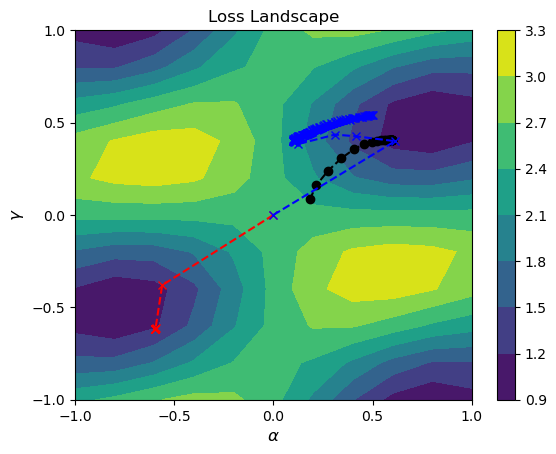

In [205]:
landscape_qaoa = QAOA.QAOA(test, n_layers=1)
cost_function = landscape_qaoa.get_loss_function()

dx = dy = np.linspace(-1.0, 1.0, 11)
dz = np.array([cost_function(torch.tensor([[xx], [yy]], dtype=torch.float32)).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11, 11))

# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Plot steps
# standard QAOA
plt.plot(params_random_x, params_random_y, linestyle="--", color="black", marker="o", label = 'QAOA rand')
#plt.plot(params_pi_x, params_pi_y, linestyle="--", color="white", marker="o", label = 'QAOA pi')
# LSTM
plt.plot(params_lstm_x, params_lstm_y, linestyle="--", color="red", marker="x", label = 'LSTM')
#plt.plot(params_lstm_qaoa_x, params_lstm_qaoa_y, linestyle="--", color="orange", marker="x", label = 'QAOA after LSTM')
# QK
plt.plot(params_qk_x, params_qk_y, linestyle="--", color="blue", marker="x", label = 'QK')
#plt.plot(params_qk_qaoa_x, params_qk_qaoa_y, linestyle="--", color="white", marker="x", label = 'QAOA after QK')

plt.yticks(np.linspace(-1, 1, 5))
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"$\gamma$", fontsize=12)
plt.title("Loss Landscape", fontsize=12)
plt.show()